### Cab-Driver Agent

In [1]:
#Sometimes this does not hide the warnings, we may need to execute this multiple times.
import warnings
warnings.filterwarnings('ignore')
import os
from sys import platform
if platform == "darwin":
    os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

In [2]:
# Importing libraries
import numpy as np
import random
import math
from collections import deque
import collections
import pickle
import time
# for building DQN model
from keras import layers
from keras import Sequential
from keras.layers import Dense, Activation, Flatten
from keras.optimizers import Nadam

# for plotting graphs
import matplotlib.pyplot as plt

%config InlineBackend.figure_format = 'retina'
%matplotlib inline
# Import the environment
from Env import CabDriver

Using TensorFlow backend.


#### Defining Time Matrix

In [3]:
# Loading the time matrix provided
Time_matrix = np.load("TM.npy")

#### Tracking the state-action pairs for checking convergence


In [4]:
data_folder = "data/"

In [5]:
# Initialise states to be tracked
# select any 4 Q-values
tracked_values = [((0, 12, 1), (1, 4)), ((1, 12, 4), (1, 2)),
                  ((2, 14, 2), (2, 3)), ((3, 18, 5), (3, 4))]

In [6]:
# Defining a function to save the Q-dictionary as a pickle file
def save_obj(obj, name):
    with open(data_folder + name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

### Agent Class

If you are using this framework, you need to fill the following to complete the following code block:
1. State and Action Size
2. Hyperparameters
3. Create a neural-network model in function 'build_model()'
4. Define epsilon-greedy strategy in function 'get_action()'
5. Complete the function 'append_sample()'. This function appends the recent experience tuple <state, action, reward, new-state> to the memory
6. Complete the 'train_model()' function with following logic:
   - If the memory size is greater than mini-batch size, you randomly sample experiences from memory as per the mini-batch size and do the following:
      - Initialise your input and output batch for training the model
      - Calculate the target Q value for each sample: reward + gamma*max(Q(s'a,))
      - Get Q(s', a) values from the last trained model
      - Update the input batch as your encoded state-action and output batch as your Q-values
      - Then fit your DQN model using the updated input and output batch.

In [7]:
import pandas as pd
def convert_to_data_frame(model_name, data):
    df = pd.DataFrame.from_records(data)
    df['name'] = model_name
    return df

In [8]:
from itertools import product

hp_learning_rate = [0.001]
hp_gamma = [0.95]
decay_rate = [0.0009]
layers = [[32, 32], [128, 128], [128, 64, 32]]

hp_params = list(product(hp_learning_rate, hp_gamma, decay_rate, layers))

In [9]:
def get_model_name(params):
    name = "4_lr_" + str(params[0]) + "_gamma_" + str(
        params[1]) + "_decay_rate_" + str(params[2]) + "_layers_" + '_'.join(
            str(x) for x in params[3])
    return name

In [10]:
def plot_tracked_values(states_tracks, name=None, big=False):
    if big:
        row = 2
        column = 2
        figsize = (16, 12)
    else:
        row = 1
        column = 4
        figsize = (16, 4)

    fig, axs = plt.subplots(row, column, figsize=figsize)
    for index, tracked_value in enumerate(tracked_values):
        xaxis = np.asarray(
            range(0, len(states_tracks[tracked_value[0]][tracked_value[1]])))
        plt.subplot(row, column, index + 1)
        plt.plot(xaxis,
                 np.asarray(states_tracks[tracked_value[0]][tracked_value[1]]))
        plt.title("({},{},{})".format(tracked_value[0][0], tracked_value[0][1],
                                      tracked_value[0][2]) + "_" +
                  "({},{})".format(tracked_value[1][0], tracked_value[1][1]))
    if name:
        fig.suptitle(name, fontsize=16)
    plt.show()

In [11]:
class AgentParam:
    def __init__(self, params):
        self.learning_rate = params.get("learning_rate", 0.01)
        self.action_size = params["action_size"]
        self.state_size = params["state_size"]
        self.action_space = params["action_space"]
        self.epsilon_max = params.get("epsilon_max", 1.0)
        self.epsilon_min = params.get("epsilon_min", 0.0001)
        self.epsilon_decay = params.get("epsilon_decay", 0.0009)
        self.discount_factor = params.get("discount_factor", 0.95)
        self.batch_size = params.get("batch_size", 32)
        self.layers = params["layers"]

    def _print(self):
        attrs = vars(self)
        print("Agent Params: ")
        print("********************************************************")
        for key, value in attrs.items():
            print(key, '->', value)
        print("********************************************************")

In [12]:
class EpsilonGreedyPolicy:
    def __init__(self, epsilon_max, epsilon_min, epsilon_decay):
        self.epsilon_max = epsilon_max
        self.epsilon_min = epsilon_min
        self.epsilon_decay = epsilon_decay

    def get_epsilon(self, episode):
        epsilon = self.epsilon_min + (self.epsilon_max - self.epsilon_min
                                      ) * np.exp(-self.epsilon_decay * episode)
        return epsilon

In [13]:
class ReplayBuffer:
    def __init__(self, batch_size, buffer_size=2000):
        self.memory = deque(maxlen=buffer_size)
        self.batch_size = batch_size

    def add(self, experience):
        self.memory.append(experience)

    def sample(self):
        return random.sample(self.memory, self.batch_size)

    def has_enough_experience(self):
        return self.length() > self.batch_size

    def length(self):
        return len(self.memory)

In [14]:
class DQNAgent:
    def __init__(self,
                 agent_param,
                 state_encoder,
                 name="DQNAgent",
                 verbose=False):
        if verbose:
            agent_param._print()
        # Define size of state and action
        self.state_size = agent_param.state_size
        self.action_size = agent_param.action_size
        self.action_space = agent_param.action_space
        self.name = name
        self.layers = agent_param.layers

        self.discount_factor = agent_param.discount_factor
        self.learning_rate = agent_param.learning_rate
        self.epsilon_greedy_policy = EpsilonGreedyPolicy(
            epsilon_max=agent_param.epsilon_max,
            epsilon_min=agent_param.epsilon_min,
            epsilon_decay=agent_param.epsilon_decay)
        self.batch_size = agent_param.batch_size
        self.memory = ReplayBuffer(batch_size=self.batch_size)
        self.epsilon = 1
        self.verbose = verbose

        # create main model and target model
        self.states_track = collections.defaultdict(dict)
        self.initialise_tracking_states()
        self.state_encoder = state_encoder
        self.model = self.build_model()

    # approximate Q function using Neural Network

    def build_model(self):
        model = Sequential()
        # Write your code here: Add layers to your neural nets
        for index, layer_dim in enumerate(self.layers):
            if index == 0:
                model.add(
                    Dense(layer_dim,
                          input_dim=self.state_size,
                          activation='relu',
                          kernel_initializer='he_uniform'))
            else:
                model.add(
                    Dense(layer_dim,
                          activation='relu',
                          kernel_initializer='he_uniform'))

        model.add(
            Dense(self.action_size,
                  activation='linear',
                  kernel_initializer='he_uniform'))

        model.compile(loss='mse', optimizer=Nadam(lr=self.learning_rate))
        if self.verbose:
            model.summary()
        return model

    def get_action(self, state, episode, requests):
        # Write your code here:
        # get action from model using epsilon-greedy policy
        # Decay in ε after we generate each sample from the environment
        self.epsilon = self.epsilon_greedy_policy.get_epsilon(episode)
        z = np.random.random()
        state_actions_index, state_actions = requests
        if z > self.epsilon:
            # Exploitation: this gets the action corresponding to max q-value of current state
            state_encode = self.state_encoder(state, self.state_size)
            q_value = self.model.predict(state_encode)
            q_value = q_value[0][state_actions_index]

            action_index = np.argmax(q_value)
            action = state_actions[action_index]
        else:
            action = self.action_space[np.random.choice(state_actions_index)]
        return action

    def save_experience(self, state, action, reward, next_state, done):
        self.memory.add((state, action, reward, next_state, done))

    def train_model(self):
        if not self.memory.has_enough_experience():
            return

        # Sample batch from the memory
        mini_batch = self.memory.sample()
        update_input = np.zeros((self.batch_size, self.state_size))
        update_target = np.zeros((self.batch_size, self.state_size))
        actions, rewards, done = [], [], []

        # Set the values of input, action, reward, target and done using memory
        # Note the order of <s,a,r,s',done>
        for index, experience in enumerate(mini_batch):
            state, action, reward, next_state, is_finished = experience

            update_input[index] = self.state_encoder(state,
                                                     self.state_size,
                                                     reshape=False)
            update_target[index] = self.state_encoder(next_state,
                                                      self.state_size,
                                                      reshape=False)

            actions.append(self.action_space.index(action))
            rewards.append(reward)
            done.append(is_finished)

        target = self.model.predict(update_input)
        target_val = self.model.predict(update_target)

        # get your target Q-value on the basis of terminal state
        for index in range(self.batch_size):
            if done[index]:
                # print(True)
                target[index][actions[index]] = rewards[index]

            else:
                target[index][
                    actions[index]] = rewards[index] + self.discount_factor * (
                        np.amax(target_val[index]))

        self.model.fit(update_input,
                       target,
                       batch_size=self.batch_size,
                       epochs=1,
                       verbose=0)

    def memory_length(self):
        return self.memory.length()

    def save(self, name):
        self.model.save_weights(name)

    def load(self, name):
        self.model.load_weights(name)

    def initialise_tracking_states(self):
        for q_values in tracked_values:
            state = q_values[0]
            action = q_values[1]
            self.states_track[state][action] = []

    def save_tracking_states(self):
        save_obj(self.states_track, self.name + '_tracked_states')

    def update_tracking_states(self):
        for state in self.states_track.keys():
            for action in self.states_track[state].keys():
                encoded_state = self.state_encoder(state, self.state_size)
                prediction = self.model.predict(encoded_state)
                action_index = self.action_space.index(list(action))
                self.states_track[state][action].append(
                    prediction[0][action_index])

In [15]:
env = CabDriver()

In [16]:
def state_encoder(state, state_size, reshape=True):
    state_encode = env.encode_state(state)
    if reshape:
        state_encode = np.reshape(state_encode, [1, state_size])
    return state_encode

### DQN block

In [17]:
def q_learning(params, max_epsilon=1.0, episodes=50000, verbose=False):
    name = get_model_name(params)
    lr = params[0]
    gamma = params[1]
    decay_rate = params[2]
    layers = params[3]
    log_threshold = episodes * .001
    threshold = episodes * .001
    model_threshold = episodes * 0.01

    print("learning_rate", lr)
    print("gamma", gamma)
    print("decay_rate", decay_rate)
    print("max_epsilon", max_epsilon)
    print("number of episodes", episodes)
    print("log_threshold", log_threshold)
    print("threshold", threshold)
    print("model_threshold", model_threshold)

    start_time = time.time()
    agent_param_dict = {
        "action_size": len(env.action_space),
        "state_size": env.state_size,
        "action_space": env.action_space,
        "epsilon_max": 1.0,
        "epsilon_min": 0.000001,
        "epsilon_decay": decay_rate,
        "discount_factor": gamma,
        "batch_size": 32,
        "layers": layers,
        "learning_rate": lr
    }

    agent_param = AgentParam(agent_param_dict)

    agent = DQNAgent(agent_param=agent_param,
                     state_encoder=state_encoder,
                     name=name)

    total_rewards = []
    data = []
    for episode in range(episodes):

        # tracking total rewards, step count
        total_reward = 0

        state = env.reset()[2]
        is_finished = False

        current_episode = episode + 1

        while not is_finished:

            action = agent.get_action(state, episode, env.get_requests(state))

            reward = env.get_reward(state, action, Time_matrix)

            next_state, is_finished, episode_time_till_now = env.get_next_state(
                state, action, Time_matrix)

            agent.save_experience(state, action, reward, next_state,
                                  is_finished)

            # every time step do the training
            agent.train_model()
            total_reward += reward
            state = next_state

            # Store the rewards
            if is_finished and current_episode % log_threshold == 0:
                total_rewards.append(total_reward)
                row = {}
                row["reward"] = total_reward
                row["episode"] = episode + 1
                data.append(row)
                if verbose:
                    print(
                        "model: {}, episode: {}, rewards: {}, replay_buffer_size: {}, episode_time: {}, epsilon: {}"
                        .format(name, current_episode, total_reward,
                                agent.memory_length(), episode_time_till_now,
                                agent.epsilon))

        if (current_episode % model_threshold) == 0:
            print("saving model for episode", current_episode, "for", name)
            agent.save("./" + name + "_dqn_cab_driver.h5")

        if (current_episode % threshold) == 0:
            agent.update_tracking_states()
            agent.save_tracking_states()

    elapsed_time = time.time() - start_time
    print("elapsed_time {} minutes for model {}".format(
        round(elapsed_time / 60, 2), name))
    df = convert_to_data_frame(name, data)
    df.to_csv(data_folder + name + ".csv")

In [18]:
EPISODES = 15000

In [19]:
import multiprocessing
from itertools import repeat

In [20]:
def run_grid_search(hp_params):
    with multiprocessing.Pool() as pool:
        pool.starmap(
            q_learning,
            zip(hp_params, repeat(1.0), repeat(EPISODES), repeat(True)))

In [21]:
run_grid_search(hp_params)

learning_rate 0.001
learning_rate 0.001
learning_rate 0.001
gamma 0.95
gamma 0.95
gamma 0.95
decay_rate 0.0009
decay_rate 0.0009
decay_rate 0.0009
max_epsilon 1.0
max_epsilon 1.0
max_epsilon 1.0
number of episodes 15000
number of episodes 15000
number of episodes 15000
log_threshold 15.0
log_threshold 15.0
log_threshold 15.0
threshold 15.0
threshold 15.0
model_threshold 150.0
model_threshold 150.0
threshold 15.0
model_threshold 150.0



model: 4_lr_0.001_gamma_0.95_decay_rate_0.0009_layers_32_32, episode: 15, rewards: -269.0, replay_buffer_size: 2000, episode_time: 717.0, epsilon: 0.9874790601725089
model: 4_lr_0.001_gamma_0.95_decay_rate_0.0009_layers_128_128, episode: 15, rewards: -371.0, replay_buffer_size: 2000, episode_time: 711.0, epsilon: 0.9874790601725089
model: 4_lr_0.001_gamma_0.95_decay_rate_0.0009_layers_128_64_32, episode: 15, rewards: -147.0, replay_buffer_size: 2000, episode_time: 714.0, epsilon: 0.9874790601725089
model: 4_lr_0.001_gamma_0.95_decay_rate_0.0009_layers_3

model: 4_lr_0.001_gamma_0.95_decay_rate_0.0009_layers_32_32, episode: 240, rewards: 215.0, replay_buffer_size: 2000, episode_time: 713.0, epsilon: 0.8064609836050919
model: 4_lr_0.001_gamma_0.95_decay_rate_0.0009_layers_32_32, episode: 255, rewards: -110.0, replay_buffer_size: 2000, episode_time: 717.0, epsilon: 0.7956469329065344
model: 4_lr_0.001_gamma_0.95_decay_rate_0.0009_layers_128_128, episode: 210, rewards: 15.0, replay_buffer_size: 2000, episode_time: 714.0, epsilon: 0.8285320213730429
model: 4_lr_0.001_gamma_0.95_decay_rate_0.0009_layers_128_64_32, episode: 210, rewards: -256.0, replay_buffer_size: 2000, episode_time: 718.0, epsilon: 0.8285320213730429
model: 4_lr_0.001_gamma_0.95_decay_rate_0.0009_layers_32_32, episode: 270, rewards: -505.0, replay_buffer_size: 2000, episode_time: 716.0, epsilon: 0.7849778908815486
model: 4_lr_0.001_gamma_0.95_decay_rate_0.0009_layers_128_128, episode: 225, rewards: 135.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.81742201386

model: 4_lr_0.001_gamma_0.95_decay_rate_0.0009_layers_128_128, episode: 420, rewards: 275.0, replay_buffer_size: 2000, episode_time: 717.0, epsilon: 0.685847799870611
model: 4_lr_0.001_gamma_0.95_decay_rate_0.0009_layers_32_32, episode: 510, rewards: 448.0, replay_buffer_size: 2000, episode_time: 713.0, epsilon: 0.63248459213815
model: 4_lr_0.001_gamma_0.95_decay_rate_0.0009_layers_128_64_32, episode: 435, rewards: -12.0, replay_buffer_size: 2000, episode_time: 716.0, epsilon: 0.6766510855685707
model: 4_lr_0.001_gamma_0.95_decay_rate_0.0009_layers_32_32, episode: 525, rewards: 162.0, replay_buffer_size: 2000, episode_time: 710.0, epsilon: 0.6240034402267901
model: 4_lr_0.001_gamma_0.95_decay_rate_0.0009_layers_128_128, episode: 435, rewards: -84.0, replay_buffer_size: 2000, episode_time: 708.0, epsilon: 0.6766510855685707
model: 4_lr_0.001_gamma_0.95_decay_rate_0.0009_layers_128_64_32, episode: 450, rewards: -37.0, replay_buffer_size: 2000, episode_time: 714.0, epsilon: 0.667577692617

model: 4_lr_0.001_gamma_0.95_decay_rate_0.0009_layers_128_64_32, episode: 645, rewards: 538.0, replay_buffer_size: 2000, episode_time: 716.0, epsilon: 0.5601228105874997
model: 4_lr_0.001_gamma_0.95_decay_rate_0.0009_layers_128_128, episode: 630, rewards: 554.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.5677357265926551
model: 4_lr_0.001_gamma_0.95_decay_rate_0.0009_layers_32_32, episode: 780, rewards: 794.0, replay_buffer_size: 2000, episode_time: 713.0, epsilon: 0.4960398642418586
model: 4_lr_0.001_gamma_0.95_decay_rate_0.0009_layers_128_64_32, episode: 660, rewards: 516.0, replay_buffer_size: 2000, episode_time: 715.0, epsilon: 0.5526119783327067
model: 4_lr_0.001_gamma_0.95_decay_rate_0.0009_layers_128_128, episode: 645, rewards: 227.0, replay_buffer_size: 2000, episode_time: 717.0, epsilon: 0.5601228105874997
model: 4_lr_0.001_gamma_0.95_decay_rate_0.0009_layers_32_32, episode: 795, rewards: 486.0, replay_buffer_size: 2000, episode_time: 715.0, epsilon: 0.489388338

model: 4_lr_0.001_gamma_0.95_decay_rate_0.0009_layers_32_32, episode: 1035, rewards: 899.0, replay_buffer_size: 2000, episode_time: 717.0, epsilon: 0.39431765483379505
model: 4_lr_0.001_gamma_0.95_decay_rate_0.0009_layers_128_128, episode: 855, rewards: 111.0, replay_buffer_size: 2000, episode_time: 715.0, epsilon: 0.46366227690975564
model: 4_lr_0.001_gamma_0.95_decay_rate_0.0009_layers_32_32, episode: 1050, rewards: 897.0, replay_buffer_size: 2000, episode_time: 716.0, epsilon: 0.38903015094848603
saving model for episode 1050 for 4_lr_0.001_gamma_0.95_decay_rate_0.0009_layers_32_32
model: 4_lr_0.001_gamma_0.95_decay_rate_0.0009_layers_128_64_32, episode: 885, rewards: 945.0, replay_buffer_size: 2000, episode_time: 717.0, epsilon: 0.451310916139639
model: 4_lr_0.001_gamma_0.95_decay_rate_0.0009_layers_128_128, episode: 870, rewards: 294.0, replay_buffer_size: 2000, episode_time: 717.0, epsilon: 0.45744491131519033
model: 4_lr_0.001_gamma_0.95_decay_rate_0.0009_layers_32_32, episode: 

model: 4_lr_0.001_gamma_0.95_decay_rate_0.0009_layers_128_64_32, episode: 1095, rewards: 315.0, replay_buffer_size: 2000, episode_time: 713.0, epsilon: 0.37358925891792494
model: 4_lr_0.001_gamma_0.95_decay_rate_0.0009_layers_128_128, episode: 1065, rewards: 441.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.3838135487027461
model: 4_lr_0.001_gamma_0.95_decay_rate_0.0009_layers_32_32, episode: 1305, rewards: 631.0, replay_buffer_size: 2000, episode_time: 716.0, epsilon: 0.30925231979183676
model: 4_lr_0.001_gamma_0.95_decay_rate_0.0009_layers_128_64_32, episode: 1110, rewards: 974.0, replay_buffer_size: 2000, episode_time: 718.0, epsilon: 0.3685797079737302
model: 4_lr_0.001_gamma_0.95_decay_rate_0.0009_layers_128_128, episode: 1080, rewards: 585.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.37866689735637693
model: 4_lr_0.001_gamma_0.95_decay_rate_0.0009_layers_32_32, episode: 1320, rewards: 924.0, replay_buffer_size: 2000, episode_time: 717.0, epsilon: 0.

model: 4_lr_0.001_gamma_0.95_decay_rate_0.0009_layers_128_128, episode: 1275, rewards: 629.0, replay_buffer_size: 2000, episode_time: 716.0, epsilon: 0.31771584891624854
model: 4_lr_0.001_gamma_0.95_decay_rate_0.0009_layers_32_32, episode: 1560, rewards: 965.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.2458344511946555
model: 4_lr_0.001_gamma_0.95_decay_rate_0.0009_layers_128_64_32, episode: 1335, rewards: 758.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.301014248575622
model: 4_lr_0.001_gamma_0.95_decay_rate_0.0009_layers_32_32, episode: 1575, rewards: 799.0, replay_buffer_size: 2000, episode_time: 717.0, epsilon: 0.24253800070899556
model: 4_lr_0.001_gamma_0.95_decay_rate_0.0009_layers_128_128, episode: 1290, rewards: 563.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.3134555203770618
model: 4_lr_0.001_gamma_0.95_decay_rate_0.0009_layers_128_64_32, episode: 1350, rewards: 1143.0, replay_buffer_size: 2000, episode_time: 716.0, epsilon: 0.2

model: 4_lr_0.001_gamma_0.95_decay_rate_0.0009_layers_128_128, episode: 1485, rewards: 801.0, replay_buffer_size: 2000, episode_time: 712.0, epsilon: 0.2630010649094265
model: 4_lr_0.001_gamma_0.95_decay_rate_0.0009_layers_128_64_32, episode: 1545, rewards: 1052.0, replay_buffer_size: 2000, episode_time: 714.0, epsilon: 0.2491757055072476
model: 4_lr_0.001_gamma_0.95_decay_rate_0.0009_layers_32_32, episode: 1830, rewards: 1208.0, replay_buffer_size: 2000, episode_time: 717.0, epsilon: 0.19280117290411855
model: 4_lr_0.001_gamma_0.95_decay_rate_0.0009_layers_128_128, episode: 1500, rewards: 962.0, replay_buffer_size: 2000, episode_time: 714.0, epsilon: 0.2594744224306012
saving model for episode 1500 for 4_lr_0.001_gamma_0.95_decay_rate_0.0009_layers_128_128
model: 4_lr_0.001_gamma_0.95_decay_rate_0.0009_layers_128_64_32, episode: 1560, rewards: 819.0, replay_buffer_size: 2000, episode_time: 717.0, epsilon: 0.2458344511946555
model: 4_lr_0.001_gamma_0.95_decay_rate_0.0009_layers_32_32, 

model: 4_lr_0.001_gamma_0.95_decay_rate_0.0009_layers_128_64_32, episode: 1770, rewards: 820.0, replay_buffer_size: 2000, episode_time: 716.0, epsilon: 0.2034986137931342
model: 4_lr_0.001_gamma_0.95_decay_rate_0.0009_layers_32_32, episode: 2085, rewards: 1308.0, replay_buffer_size: 2000, episode_time: 717.0, epsilon: 0.15326382820021411
model: 4_lr_0.001_gamma_0.95_decay_rate_0.0009_layers_128_128, episode: 1710, rewards: 741.0, replay_buffer_size: 2000, episode_time: 715.0, epsilon: 0.21478959793395433
model: 4_lr_0.001_gamma_0.95_decay_rate_0.0009_layers_128_64_32, episode: 1785, rewards: 1227.0, replay_buffer_size: 2000, episode_time: 714.0, epsilon: 0.20076985656111757
model: 4_lr_0.001_gamma_0.95_decay_rate_0.0009_layers_32_32, episode: 2100, rewards: 1262.0, replay_buffer_size: 2000, episode_time: 718.0, epsilon: 0.15120868345893085
saving model for episode 2100 for 4_lr_0.001_gamma_0.95_decay_rate_0.0009_layers_32_32
model: 4_lr_0.001_gamma_0.95_decay_rate_0.0009_layers_128_128

model: 4_lr_0.001_gamma_0.95_decay_rate_0.0009_layers_32_32, episode: 2340, rewards: 1114.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.12183436847737124
model: 4_lr_0.001_gamma_0.95_decay_rate_0.0009_layers_128_128, episode: 1920, rewards: 904.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.17780010316160777
model: 4_lr_0.001_gamma_0.95_decay_rate_0.0009_layers_128_64_32, episode: 1995, rewards: 941.0, replay_buffer_size: 2000, episode_time: 718.0, epsilon: 0.16619475042582355
model: 4_lr_0.001_gamma_0.95_decay_rate_0.0009_layers_32_32, episode: 2355, rewards: 1219.0, replay_buffer_size: 2000, episode_time: 718.0, epsilon: 0.12020067027749194
model: 4_lr_0.001_gamma_0.95_decay_rate_0.0009_layers_128_128, episode: 1935, rewards: 810.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.17541594454886106
model: 4_lr_0.001_gamma_0.95_decay_rate_0.0009_layers_32_32, episode: 2370, rewards: 1404.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0

model: 4_lr_0.001_gamma_0.95_decay_rate_0.0009_layers_128_128, episode: 2130, rewards: 638.0, replay_buffer_size: 2000, episode_time: 717.0, epsilon: 0.14718069849960388
model: 4_lr_0.001_gamma_0.95_decay_rate_0.0009_layers_128_64_32, episode: 2205, rewards: 1130.0, replay_buffer_size: 2000, episode_time: 717.0, epsilon: 0.13757394409948887
model: 4_lr_0.001_gamma_0.95_decay_rate_0.0009_layers_32_32, episode: 2610, rewards: 1065.0, replay_buffer_size: 2000, episode_time: 717.0, epsilon: 0.09555144032363573
model: 4_lr_0.001_gamma_0.95_decay_rate_0.0009_layers_128_128, episode: 2145, rewards: 1098.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.1452071241701521
model: 4_lr_0.001_gamma_0.95_decay_rate_0.0009_layers_32_32, episode: 2625, rewards: 1212.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.09427017736337052
model: 4_lr_0.001_gamma_0.95_decay_rate_0.0009_layers_128_64_32, episode: 2220, rewards: 1251.0, replay_buffer_size: 2000, episode_time: 719.0, epsil

model: 4_lr_0.001_gamma_0.95_decay_rate_0.0009_layers_128_128, episode: 2340, rewards: 1093.0, replay_buffer_size: 2000, episode_time: 718.0, epsilon: 0.12183436847737124
model: 4_lr_0.001_gamma_0.95_decay_rate_0.0009_layers_32_32, episode: 2865, rewards: 1395.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.07595700408023998
model: 4_lr_0.001_gamma_0.95_decay_rate_0.0009_layers_128_64_32, episode: 2430, rewards: 846.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.11235496381727808
model: 4_lr_0.001_gamma_0.95_decay_rate_0.0009_layers_32_32, episode: 2880, rewards: 1279.0, replay_buffer_size: 2000, episode_time: 714.0, epsilon: 0.07493848847415657
model: 4_lr_0.001_gamma_0.95_decay_rate_0.0009_layers_128_128, episode: 2355, rewards: 950.0, replay_buffer_size: 2000, episode_time: 716.0, epsilon: 0.12020067027749194
model: 4_lr_0.001_gamma_0.95_decay_rate_0.0009_layers_128_64_32, episode: 2445, rewards: 866.0, replay_buffer_size: 2000, episode_time: 717.0, epsilo

saving model for episode 2550 for 4_lr_0.001_gamma_0.95_decay_rate_0.0009_layers_128_128
model: 4_lr_0.001_gamma_0.95_decay_rate_0.0009_layers_128_64_32, episode: 2640, rewards: 1243.0, replay_buffer_size: 2000, episode_time: 715.0, epsilon: 0.09300609522161116
model: 4_lr_0.001_gamma_0.95_decay_rate_0.0009_layers_32_32, episode: 3135, rewards: 1332.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.05957113030004833
model: 4_lr_0.001_gamma_0.95_decay_rate_0.0009_layers_128_128, episode: 2565, rewards: 1130.0, replay_buffer_size: 2000, episode_time: 716.0, epsilon: 0.09950066516486386
model: 4_lr_0.001_gamma_0.95_decay_rate_0.0009_layers_128_64_32, episode: 2655, rewards: 1143.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.09175896351588828
model: 4_lr_0.001_gamma_0.95_decay_rate_0.0009_layers_32_32, episode: 3150, rewards: 1323.0, replay_buffer_size: 2000, episode_time: 716.0, epsilon: 0.05877233752386535
saving model for episode 3150 for 4_lr_0.001_gamma_0.95_

model: 4_lr_0.001_gamma_0.95_decay_rate_0.0009_layers_32_32, episode: 3390, rewards: 1146.0, replay_buffer_size: 2000, episode_time: 713.0, epsilon: 0.0473551413812998
model: 4_lr_0.001_gamma_0.95_decay_rate_0.0009_layers_128_128, episode: 2760, rewards: 1255.0, replay_buffer_size: 2000, episode_time: 714.0, epsilon: 0.08348494007955853
model: 4_lr_0.001_gamma_0.95_decay_rate_0.0009_layers_128_64_32, episode: 2865, rewards: 1425.0, replay_buffer_size: 2000, episode_time: 715.0, epsilon: 0.07595700408023998
model: 4_lr_0.001_gamma_0.95_decay_rate_0.0009_layers_32_32, episode: 3405, rewards: 1638.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.04672015626598775
model: 4_lr_0.001_gamma_0.95_decay_rate_0.0009_layers_128_128, episode: 2775, rewards: 1134.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.08236548024411831
model: 4_lr_0.001_gamma_0.95_decay_rate_0.0009_layers_128_64_32, episode: 2880, rewards: 1227.0, replay_buffer_size: 2000, episode_time: 712.0, epsi

model: 4_lr_0.001_gamma_0.95_decay_rate_0.0009_layers_128_128, episode: 2970, rewards: 1269.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.06910787912357022
model: 4_lr_0.001_gamma_0.95_decay_rate_0.0009_layers_128_64_32, episode: 3075, rewards: 1272.0, replay_buffer_size: 2000, episode_time: 715.0, epsilon: 0.06287635528007277
model: 4_lr_0.001_gamma_0.95_decay_rate_0.0009_layers_32_32, episode: 3660, rewards: 1386.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.0371395041444643
model: 4_lr_0.001_gamma_0.95_decay_rate_0.0009_layers_128_128, episode: 2985, rewards: 942.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.0681812053770061
model: 4_lr_0.001_gamma_0.95_decay_rate_0.0009_layers_32_32, episode: 3675, rewards: 1582.0, replay_buffer_size: 2000, episode_time: 715.0, epsilon: 0.03664150340685612
model: 4_lr_0.001_gamma_0.95_decay_rate_0.0009_layers_128_64_32, episode: 3090, rewards: 1015.0, replay_buffer_size: 2000, episode_time: 717.0, epsilo

model: 4_lr_0.001_gamma_0.95_decay_rate_0.0009_layers_32_32, episode: 3915, rewards: 1790.0, replay_buffer_size: 2000, episode_time: 716.0, epsilon: 0.02952354707331948
model: 4_lr_0.001_gamma_0.95_decay_rate_0.0009_layers_128_64_32, episode: 3285, rewards: 1467.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.05204837070448172
model: 4_lr_0.001_gamma_0.95_decay_rate_0.0009_layers_32_32, episode: 3930, rewards: 1191.0, replay_buffer_size: 2000, episode_time: 716.0, epsilon: 0.029127670864590244
model: 4_lr_0.001_gamma_0.95_decay_rate_0.0009_layers_128_128, episode: 3195, rewards: 1157.0, replay_buffer_size: 2000, episode_time: 716.0, epsilon: 0.05643965403476137
model: 4_lr_0.001_gamma_0.95_decay_rate_0.0009_layers_128_64_32, episode: 3300, rewards: 1376.0, replay_buffer_size: 2000, episode_time: 717.0, epsilon: 0.051350452745789185
saving model for episode 3300 for 4_lr_0.001_gamma_0.95_decay_rate_0.0009_layers_128_64_32
model: 4_lr_0.001_gamma_0.95_decay_rate_0.0009_layer

model: 4_lr_0.001_gamma_0.95_decay_rate_0.0009_layers_32_32, episode: 4170, rewards: 1839.0, replay_buffer_size: 2000, episode_time: 718.0, epsilon: 0.023469386941650103
model: 4_lr_0.001_gamma_0.95_decay_rate_0.0009_layers_128_64_32, episode: 3510, rewards: 1402.0, replay_buffer_size: 2000, episode_time: 714.0, epsilon: 0.04250738410912313
model: 4_lr_0.001_gamma_0.95_decay_rate_0.0009_layers_128_128, episode: 3405, rewards: 1395.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.04672015626598775
model: 4_lr_0.001_gamma_0.95_decay_rate_0.0009_layers_32_32, episode: 4185, rewards: 1631.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.023154692683584294
model: 4_lr_0.001_gamma_0.95_decay_rate_0.0009_layers_128_64_32, episode: 3525, rewards: 1152.0, replay_buffer_size: 2000, episode_time: 716.0, epsilon: 0.04193740394629649
model: 4_lr_0.001_gamma_0.95_decay_rate_0.0009_layers_32_32, episode: 4200, rewards: 1461.0, replay_buffer_size: 2000, episode_time: 718.0, eps

saving model for episode 3600 for 4_lr_0.001_gamma_0.95_decay_rate_0.0009_layers_128_128
model: 4_lr_0.001_gamma_0.95_decay_rate_0.0009_layers_128_64_32, episode: 3720, rewards: 1269.0, replay_buffer_size: 2000, episode_time: 710.0, epsilon: 0.03518721121391558
model: 4_lr_0.001_gamma_0.95_decay_rate_0.0009_layers_32_32, episode: 4440, rewards: 1414.0, replay_buffer_size: 2000, episode_time: 716.0, epsilon: 0.018406587352504555
model: 4_lr_0.001_gamma_0.95_decay_rate_0.0009_layers_128_128, episode: 3615, rewards: 1151.0, replay_buffer_size: 2000, episode_time: 714.0, epsilon: 0.038674487161147394
model: 4_lr_0.001_gamma_0.95_decay_rate_0.0009_layers_128_64_32, episode: 3735, rewards: 1242.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.03471538932604401
model: 4_lr_0.001_gamma_0.95_decay_rate_0.0009_layers_32_32, episode: 4455, rewards: 1632.0, replay_buffer_size: 2000, episode_time: 716.0, epsilon: 0.018159781610356075
model: 4_lr_0.001_gamma_0.95_decay_rate_0.0009_layers

model: 4_lr_0.001_gamma_0.95_decay_rate_0.0009_layers_32_32, episode: 4695, rewards: 1323.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.01463217138247484
model: 4_lr_0.001_gamma_0.95_decay_rate_0.0009_layers_128_128, episode: 3810, rewards: 1269.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.03244950200731048
model: 4_lr_0.001_gamma_0.95_decay_rate_0.0009_layers_128_64_32, episode: 3945, rewards: 1296.0, replay_buffer_size: 2000, episode_time: 716.0, epsilon: 0.028737103072246917
model: 4_lr_0.001_gamma_0.95_decay_rate_0.0009_layers_32_32, episode: 4710, rewards: 1775.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.014435977854803356
model: 4_lr_0.001_gamma_0.95_decay_rate_0.0009_layers_128_128, episode: 3825, rewards: 1359.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.03201439083882983
model: 4_lr_0.001_gamma_0.95_decay_rate_0.0009_layers_32_32, episode: 4725, rewards: 1809.0, replay_buffer_size: 2000, episode_time: 719.0, epsil

model: 4_lr_0.001_gamma_0.95_decay_rate_0.0009_layers_32_32, episode: 4965, rewards: 1510.0, replay_buffer_size: 2000, episode_time: 718.0, epsilon: 0.011475810928384615
model: 4_lr_0.001_gamma_0.95_decay_rate_0.0009_layers_128_128, episode: 4020, rewards: 1183.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.026861432124108593
model: 4_lr_0.001_gamma_0.95_decay_rate_0.0009_layers_128_64_32, episode: 4155, rewards: 909.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.023788358378195082
model: 4_lr_0.001_gamma_0.95_decay_rate_0.0009_layers_32_32, episode: 4980, rewards: 1215.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.011321941933445528
model: 4_lr_0.001_gamma_0.95_decay_rate_0.0009_layers_128_128, episode: 4035, rewards: 1323.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.02650125296992813
model: 4_lr_0.001_gamma_0.95_decay_rate_0.0009_layers_128_64_32, episode: 4170, rewards: 1224.0, replay_buffer_size: 2000, episode_time: 719.0, 

model: 4_lr_0.001_gamma_0.95_decay_rate_0.0009_layers_128_64_32, episode: 4365, rewards: 1311.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.019691854295381808
model: 4_lr_0.001_gamma_0.95_decay_rate_0.0009_layers_128_128, episode: 4230, rewards: 1440.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.022235703276326853
model: 4_lr_0.001_gamma_0.95_decay_rate_0.0009_layers_32_32, episode: 5235, rewards: 1237.0, replay_buffer_size: 2000, episode_time: 713.0, epsilon: 0.009000367337046606
model: 4_lr_0.001_gamma_0.95_decay_rate_0.0009_layers_128_64_32, episode: 4380, rewards: 1403.0, replay_buffer_size: 2000, episode_time: 714.0, epsilon: 0.019427814044188838
model: 4_lr_0.001_gamma_0.95_decay_rate_0.0009_layers_128_128, episode: 4245, rewards: 1421.0, replay_buffer_size: 2000, episode_time: 714.0, epsilon: 0.02193755183250355
model: 4_lr_0.001_gamma_0.95_decay_rate_0.0009_layers_32_32, episode: 5250, rewards: 1575.0, replay_buffer_size: 2000, episode_time: 719.0,

model: 4_lr_0.001_gamma_0.95_decay_rate_0.0009_layers_128_64_32, episode: 4575, rewards: 1602.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.016300823491009097
model: 4_lr_0.001_gamma_0.95_decay_rate_0.0009_layers_128_128, episode: 4440, rewards: 1204.0, replay_buffer_size: 2000, episode_time: 712.0, epsilon: 0.018406587352504555
model: 4_lr_0.001_gamma_0.95_decay_rate_0.0009_layers_32_32, episode: 5505, rewards: 1744.0, replay_buffer_size: 2000, episode_time: 718.0, epsilon: 0.00705894744441184
model: 4_lr_0.001_gamma_0.95_decay_rate_0.0009_layers_128_64_32, episode: 4590, rewards: 1428.0, replay_buffer_size: 2000, episode_time: 708.0, epsilon: 0.016082254533847276
model: 4_lr_0.001_gamma_0.95_decay_rate_0.0009_layers_128_128, episode: 4455, rewards: 1287.0, replay_buffer_size: 2000, episode_time: 718.0, epsilon: 0.018159781610356075
model: 4_lr_0.001_gamma_0.95_decay_rate_0.0009_layers_32_32, episode: 5520, rewards: 1778.0, replay_buffer_size: 2000, episode_time: 718.0,

model: 4_lr_0.001_gamma_0.95_decay_rate_0.0009_layers_128_128, episode: 4650, rewards: 1538.0, replay_buffer_size: 2000, episode_time: 714.0, epsilon: 0.015236896858194513
saving model for episode 4650 for 4_lr_0.001_gamma_0.95_decay_rate_0.0009_layers_128_128
model: 4_lr_0.001_gamma_0.95_decay_rate_0.0009_layers_32_32, episode: 5760, rewards: 1737.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.005611580998581279
model: 4_lr_0.001_gamma_0.95_decay_rate_0.0009_layers_128_64_32, episode: 4800, rewards: 1509.0, replay_buffer_size: 2000, episode_time: 715.0, epsilon: 0.013312845513842283
saving model for episode 4800 for 4_lr_0.001_gamma_0.95_decay_rate_0.0009_layers_128_64_32
model: 4_lr_0.001_gamma_0.95_decay_rate_0.0009_layers_128_128, episode: 4665, rewards: 1170.0, replay_buffer_size: 2000, episode_time: 710.0, epsilon: 0.015032594395069224
model: 4_lr_0.001_gamma_0.95_decay_rate_0.0009_layers_32_32, episode: 5775, rewards: 1620.0, replay_buffer_size: 2000, episode_time:

model: 4_lr_0.001_gamma_0.95_decay_rate_0.0009_layers_32_32, episode: 6015, rewards: 1529.0, replay_buffer_size: 2000, episode_time: 713.0, epsilon: 0.004461024587823281
model: 4_lr_0.001_gamma_0.95_decay_rate_0.0009_layers_128_64_32, episode: 5010, rewards: 1431.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.011020366095563464
model: 4_lr_0.001_gamma_0.95_decay_rate_0.0009_layers_128_128, episode: 4860, rewards: 1422.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.012613069836606103
model: 4_lr_0.001_gamma_0.95_decay_rate_0.0009_layers_32_32, episode: 6030, rewards: 1391.0, replay_buffer_size: 2000, episode_time: 713.0, epsilon: 0.0044012188528952684
model: 4_lr_0.001_gamma_0.95_decay_rate_0.0009_layers_128_64_32, episode: 5025, rewards: 1325.0, replay_buffer_size: 2000, episode_time: 714.0, epsilon: 0.010872604289589288
model: 4_lr_0.001_gamma_0.95_decay_rate_0.0009_layers_32_32, episode: 6045, rewards: 1426.0, replay_buffer_size: 2000, episode_time: 713.0,

model: 4_lr_0.001_gamma_0.95_decay_rate_0.0009_layers_32_32, episode: 6285, rewards: 1404.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.003498870234950526
model: 4_lr_0.001_gamma_0.95_decay_rate_0.0009_layers_128_128, episode: 5070, rewards: 1357.0, replay_buffer_size: 2000, episode_time: 717.0, epsilon: 0.010441101232234186
model: 4_lr_0.001_gamma_0.95_decay_rate_0.0009_layers_128_64_32, episode: 5235, rewards: 1422.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.009000367337046606
model: 4_lr_0.001_gamma_0.95_decay_rate_0.0009_layers_32_32, episode: 6300, rewards: 1279.0, replay_buffer_size: 2000, episode_time: 714.0, epsilon: 0.0034519663006863134
saving model for episode 6300 for 4_lr_0.001_gamma_0.95_decay_rate_0.0009_layers_32_32
model: 4_lr_0.001_gamma_0.95_decay_rate_0.0009_layers_128_128, episode: 5085, rewards: 1354.0, replay_buffer_size: 2000, episode_time: 717.0, epsilon: 0.010301106953139572
model: 4_lr_0.001_gamma_0.95_decay_rate_0.0009_layers_

model: 4_lr_0.001_gamma_0.95_decay_rate_0.0009_layers_32_32, episode: 6540, rewards: 1431.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.002781565374038694
model: 4_lr_0.001_gamma_0.95_decay_rate_0.0009_layers_128_64_32, episode: 5445, rewards: 1521.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.007450554850396498
model: 4_lr_0.001_gamma_0.95_decay_rate_0.0009_layers_32_32, episode: 6555, rewards: 1587.0, replay_buffer_size: 2000, episode_time: 717.0, epsilon: 0.0027442799841411176
model: 4_lr_0.001_gamma_0.95_decay_rate_0.0009_layers_128_128, episode: 5280, rewards: 1449.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.008643174928570519
model: 4_lr_0.001_gamma_0.95_decay_rate_0.0009_layers_128_64_32, episode: 5460, rewards: 1433.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.007350661656100916
model: 4_lr_0.001_gamma_0.95_decay_rate_0.0009_layers_32_32, episode: 6570, rewards: 1564.0, replay_buffer_size: 2000, episode_time: 717.0,

model: 4_lr_0.001_gamma_0.95_decay_rate_0.0009_layers_128_64_32, episode: 5655, rewards: 1404.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.0061676409860405255
model: 4_lr_0.001_gamma_0.95_decay_rate_0.0009_layers_128_128, episode: 5475, rewards: 1080.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.00725210795798558
model: 4_lr_0.001_gamma_0.95_decay_rate_0.0009_layers_32_32, episode: 6825, rewards: 1754.0, replay_buffer_size: 2000, episode_time: 717.0, epsilon: 0.0021524763458615668
model: 4_lr_0.001_gamma_0.95_decay_rate_0.0009_layers_128_64_32, episode: 5670, rewards: 936.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.006084950747692008
model: 4_lr_0.001_gamma_0.95_decay_rate_0.0009_layers_128_128, episode: 5490, rewards: 1470.0, replay_buffer_size: 2000, episode_time: 715.0, epsilon: 0.0071548757943662
model: 4_lr_0.001_gamma_0.95_decay_rate_0.0009_layers_32_32, episode: 6840, rewards: 1674.0, replay_buffer_size: 2000, episode_time: 719.0, 

model: 4_lr_0.001_gamma_0.95_decay_rate_0.0009_layers_32_32, episode: 7080, rewards: 1665.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.0017112751756171362
model: 4_lr_0.001_gamma_0.95_decay_rate_0.0009_layers_128_128, episode: 5685, rewards: 1424.0, replay_buffer_size: 2000, episode_time: 718.0, epsilon: 0.006003369326207266
model: 4_lr_0.001_gamma_0.95_decay_rate_0.0009_layers_32_32, episode: 7095, rewards: 1665.0, replay_buffer_size: 2000, episode_time: 714.0, epsilon: 0.0016883416106125472
model: 4_lr_0.001_gamma_0.95_decay_rate_0.0009_layers_128_64_32, episode: 5880, rewards: 1751.0, replay_buffer_size: 2000, episode_time: 716.0, epsilon: 0.00503721233633478
model: 4_lr_0.001_gamma_0.95_decay_rate_0.0009_layers_128_128, episode: 5700, rewards: 1287.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.005922881853146409
saving model for episode 5700 for 4_lr_0.001_gamma_0.95_decay_rate_0.0009_layers_128_128
model: 4_lr_0.001_gamma_0.95_decay_rate_0.0009_layer

saving model for episode 7350 for 4_lr_0.001_gamma_0.95_decay_rate_0.0009_layers_32_32
model: 4_lr_0.001_gamma_0.95_decay_rate_0.0009_layers_128_128, episode: 5880, rewards: 1233.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.00503721233633478
model: 4_lr_0.001_gamma_0.95_decay_rate_0.0009_layers_128_64_32, episode: 6090, rewards: 1327.0, replay_buffer_size: 2000, episode_time: 715.0, epsilon: 0.00416990861686749
model: 4_lr_0.001_gamma_0.95_decay_rate_0.0009_layers_32_32, episode: 7365, rewards: 1656.0, replay_buffer_size: 2000, episode_time: 718.0, epsilon: 0.0013243339592048382
model: 4_lr_0.001_gamma_0.95_decay_rate_0.0009_layers_128_128, episode: 5895, rewards: 1512.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.004969680336432734
model: 4_lr_0.001_gamma_0.95_decay_rate_0.0009_layers_32_32, episode: 7380, rewards: 1789.0, replay_buffer_size: 2000, episode_time: 718.0, epsilon: 0.001306588998739483
model: 4_lr_0.001_gamma_0.95_decay_rate_0.0009_layers_12

model: 4_lr_0.001_gamma_0.95_decay_rate_0.0009_layers_128_128, episode: 6075, rewards: 1269.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.004226570490291225
model: 4_lr_0.001_gamma_0.95_decay_rate_0.0009_layers_32_32, episode: 7650, rewards: 1647.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.0010249362604049046
saving model for episode 7650 for 4_lr_0.001_gamma_0.95_decay_rate_0.0009_layers_32_32
model: 4_lr_0.001_gamma_0.95_decay_rate_0.0009_layers_128_64_32, episode: 6300, rewards: 1390.0, replay_buffer_size: 2000, episode_time: 715.0, epsilon: 0.0034519663006863134
saving model for episode 6300 for 4_lr_0.001_gamma_0.95_decay_rate_0.0009_layers_128_64_32
model: 4_lr_0.001_gamma_0.95_decay_rate_0.0009_layers_128_128, episode: 6090, rewards: 1197.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.00416990861686749
model: 4_lr_0.001_gamma_0.95_decay_rate_0.0009_layers_32_32, episode: 7665, rewards: 1529.0, replay_buffer_size: 2000, episode_time: 

model: 4_lr_0.001_gamma_0.95_decay_rate_0.0009_layers_32_32, episode: 7920, rewards: 1700.0, replay_buffer_size: 2000, episode_time: 714.0, epsilon: 0.0008040440409533417
model: 4_lr_0.001_gamma_0.95_decay_rate_0.0009_layers_128_64_32, episode: 6510, rewards: 963.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.0028576633387663733
model: 4_lr_0.001_gamma_0.95_decay_rate_0.0009_layers_128_128, episode: 6270, rewards: 1296.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.003546411665746945
model: 4_lr_0.001_gamma_0.95_decay_rate_0.0009_layers_32_32, episode: 7935, rewards: 1739.0, replay_buffer_size: 2000, episode_time: 718.0, epsilon: 0.0007932757955988436
model: 4_lr_0.001_gamma_0.95_decay_rate_0.0009_layers_128_64_32, episode: 6525, rewards: 1404.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.0028193575296721206
model: 4_lr_0.001_gamma_0.95_decay_rate_0.0009_layers_128_128, episode: 6285, rewards: 1428.0, replay_buffer_size: 2000, episode_time: 71

saving model for episode 6450 for 4_lr_0.001_gamma_0.95_decay_rate_0.0009_layers_128_128
model: 4_lr_0.001_gamma_0.95_decay_rate_0.0009_layers_32_32, episode: 8190, rewards: 1440.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.0006308045656237049
model: 4_lr_0.001_gamma_0.95_decay_rate_0.0009_layers_128_64_32, episode: 6735, rewards: 1332.0, replay_buffer_size: 2000, episode_time: 713.0, epsilon: 0.0023339983341040837
model: 4_lr_0.001_gamma_0.95_decay_rate_0.0009_layers_32_32, episode: 8205, rewards: 1314.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.0006223593375388696
model: 4_lr_0.001_gamma_0.95_decay_rate_0.0009_layers_128_128, episode: 6465, rewards: 1278.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.0029757329759367533
model: 4_lr_0.001_gamma_0.95_decay_rate_0.0009_layers_32_32, episode: 8220, rewards: 1575.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.000614027353913185
model: 4_lr_0.001_gamma_0.95_decay_rate_0.0009_laye

model: 4_lr_0.001_gamma_0.95_decay_rate_0.0009_layers_128_64_32, episode: 6945, rewards: 1506.0, replay_buffer_size: 2000, episode_time: 715.0, epsilon: 0.0019322245411126523
model: 4_lr_0.001_gamma_0.95_decay_rate_0.0009_layers_128_128, episode: 6645, rewards: 1233.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.0025308354952412043
model: 4_lr_0.001_gamma_0.95_decay_rate_0.0009_layers_32_32, episode: 8475, rewards: 1377.0, replay_buffer_size: 2000, episode_time: 718.0, epsilon: 0.0004883144282477006
model: 4_lr_0.001_gamma_0.95_decay_rate_0.0009_layers_128_64_32, episode: 6960, rewards: 1269.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.0019063282033867169
model: 4_lr_0.001_gamma_0.95_decay_rate_0.0009_layers_32_32, episode: 8490, rewards: 1575.0, replay_buffer_size: 2000, episode_time: 709.0, epsilon: 0.00048177989083686553
model: 4_lr_0.001_gamma_0.95_decay_rate_0.0009_layers_128_128, episode: 6660, rewards: 1422.0, replay_buffer_size: 2000, episode_time:

model: 4_lr_0.001_gamma_0.95_decay_rate_0.0009_layers_128_64_32, episode: 7170, rewards: 1367.0, replay_buffer_size: 2000, episode_time: 715.0, epsilon: 0.001578204977588443
model: 4_lr_0.001_gamma_0.95_decay_rate_0.0009_layers_32_32, episode: 8745, rewards: 1665.0, replay_buffer_size: 2000, episode_time: 718.0, epsilon: 0.0003831868243245446
model: 4_lr_0.001_gamma_0.95_decay_rate_0.0009_layers_128_64_32, episode: 7185, rewards: 1568.0, replay_buffer_size: 2000, episode_time: 715.0, epsilon: 0.0015570557886188747
model: 4_lr_0.001_gamma_0.95_decay_rate_0.0009_layers_128_128, episode: 6840, rewards: 1152.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.0021236265892042206
model: 4_lr_0.001_gamma_0.95_decay_rate_0.0009_layers_32_32, episode: 8760, rewards: 1550.0, replay_buffer_size: 2000, episode_time: 718.0, epsilon: 0.00037806197277755204
model: 4_lr_0.001_gamma_0.95_decay_rate_0.0009_layers_128_64_32, episode: 7200, rewards: 1371.0, replay_buffer_size: 2000, episode_time

saving model for episode 9000 for 4_lr_0.001_gamma_0.95_decay_rate_0.0009_layers_32_32
model: 4_lr_0.001_gamma_0.95_decay_rate_0.0009_layers_128_64_32, episode: 7395, rewards: 1332.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.0012890819854829384
model: 4_lr_0.001_gamma_0.95_decay_rate_0.0009_layers_32_32, episode: 9015, rewards: 1647.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.00030073823925655445
model: 4_lr_0.001_gamma_0.95_decay_rate_0.0009_layers_128_128, episode: 7035, rewards: 1395.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.001781963088577097
model: 4_lr_0.001_gamma_0.95_decay_rate_0.0009_layers_128_64_32, episode: 7410, rewards: 1134.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.0012718097287335787
model: 4_lr_0.001_gamma_0.95_decay_rate_0.0009_layers_32_32, episode: 9030, rewards: 1512.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.00029671896417594033
model: 4_lr_0.001_gamma_0.95_decay_rate_0.0009_

model: 4_lr_0.001_gamma_0.95_decay_rate_0.0009_layers_32_32, episode: 9270, rewards: 1455.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.00023927120887001373
model: 4_lr_0.001_gamma_0.95_decay_rate_0.0009_layers_128_64_32, episode: 7620, rewards: 1713.0, replay_buffer_size: 2000, episode_time: 715.0, epsilon: 0.0010529591460220512
model: 4_lr_0.001_gamma_0.95_decay_rate_0.0009_layers_32_32, episode: 9285, rewards: 1449.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.00023607616263695923
model: 4_lr_0.001_gamma_0.95_decay_rate_0.0009_layers_128_128, episode: 7230, rewards: 1080.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.00149529463430174
model: 4_lr_0.001_gamma_0.95_decay_rate_0.0009_layers_32_32, episode: 9300, rewards: 1764.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.0002329239596852213
saving model for episode 9300 for 4_lr_0.001_gamma_0.95_decay_rate_0.0009_layers_32_32
model: 4_lr_0.001_gamma_0.95_decay_rate_0.0009_layer

model: 4_lr_0.001_gamma_0.95_decay_rate_0.0009_layers_128_128, episode: 7410, rewards: 1521.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.0012718097287335787
model: 4_lr_0.001_gamma_0.95_decay_rate_0.0009_layers_32_32, episode: 9540, rewards: 1530.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.0001878693216686643
model: 4_lr_0.001_gamma_0.95_decay_rate_0.0009_layers_128_64_32, episode: 7845, rewards: 1314.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.0008601208148016617
model: 4_lr_0.001_gamma_0.95_decay_rate_0.0009_layers_32_32, episode: 9555, rewards: 1233.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.00018536353792289654
model: 4_lr_0.001_gamma_0.95_decay_rate_0.0009_layers_128_128, episode: 7425, rewards: 1410.0, replay_buffer_size: 2000, episode_time: 713.0, epsilon: 0.0012547690805748055
model: 4_lr_0.001_gamma_0.95_decay_rate_0.0009_layers_128_64_32, episode: 7860, rewards: 1336.0, replay_buffer_size: 2000, episode_time:

model: 4_lr_0.001_gamma_0.95_decay_rate_0.0009_layers_128_128, episode: 7605, rewards: 1386.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.001067256887099338
model: 4_lr_0.001_gamma_0.95_decay_rate_0.0009_layers_32_32, episode: 9810, rewards: 1503.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.00014755628578254747
model: 4_lr_0.001_gamma_0.95_decay_rate_0.0009_layers_128_64_32, episode: 8070, rewards: 1107.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.0007026323563671917
model: 4_lr_0.001_gamma_0.95_decay_rate_0.0009_layers_32_32, episode: 9825, rewards: 1620.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.00014559107097106977
model: 4_lr_0.001_gamma_0.95_decay_rate_0.0009_layers_128_128, episode: 7620, rewards: 1404.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.0010529591460220512
model: 4_lr_0.001_gamma_0.95_decay_rate_0.0009_layers_32_32, episode: 9840, rewards: 1458.0, replay_buffer_size: 2000, episode_time: 719

model: 4_lr_0.001_gamma_0.95_decay_rate_0.0009_layers_128_64_32, episode: 8265, rewards: 1287.0, replay_buffer_size: 2000, episode_time: 715.0, epsilon: 0.0005896957860590131
model: 4_lr_0.001_gamma_0.95_decay_rate_0.0009_layers_128_128, episode: 7800, rewards: 1486.0, replay_buffer_size: 2000, episode_time: 709.0, epsilon: 0.0008956294032701082
saving model for episode 7800 for 4_lr_0.001_gamma_0.95_decay_rate_0.0009_layers_128_128
model: 4_lr_0.001_gamma_0.95_decay_rate_0.0009_layers_32_32, episode: 10095, rewards: 1629.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.00011439865810833142
model: 4_lr_0.001_gamma_0.95_decay_rate_0.0009_layers_128_64_32, episode: 8280, rewards: 1809.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.0005818017972611926
model: 4_lr_0.001_gamma_0.95_decay_rate_0.0009_layers_128_128, episode: 7815, rewards: 1008.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.000883633063811162
model: 4_lr_0.001_gamma_0.95_decay_rate_0.0

model: 4_lr_0.001_gamma_0.95_decay_rate_0.0009_layers_128_64_32, episode: 8475, rewards: 1476.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.0004883144282477006
model: 4_lr_0.001_gamma_0.95_decay_rate_0.0009_layers_32_32, episode: 10365, rewards: 1485.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 8.993533725428423e-05
model: 4_lr_0.001_gamma_0.95_decay_rate_0.0009_layers_128_128, episode: 7995, rewards: 1494.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.000751627525954601
model: 4_lr_0.001_gamma_0.95_decay_rate_0.0009_layers_32_32, episode: 10380, rewards: 1480.0, replay_buffer_size: 2000, episode_time: 709.0, epsilon: 8.874277808766353e-05
model: 4_lr_0.001_gamma_0.95_decay_rate_0.0009_layers_128_64_32, episode: 8490, rewards: 1433.0, replay_buffer_size: 2000, episode_time: 715.0, epsilon: 0.00048177989083686553
model: 4_lr_0.001_gamma_0.95_decay_rate_0.0009_layers_128_128, episode: 8010, rewards: 1494.0, replay_buffer_size: 2000, episode_time

saving model for episode 8700 for 4_lr_0.001_gamma_0.95_decay_rate_0.0009_layers_128_64_32
model: 4_lr_0.001_gamma_0.95_decay_rate_0.0009_layers_32_32, episode: 10635, rewards: 1652.0, replay_buffer_size: 2000, episode_time: 715.0, epsilon: 7.074945157620149e-05
model: 4_lr_0.001_gamma_0.95_decay_rate_0.0009_layers_128_128, episode: 8175, rewards: 954.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.000639364577333886
model: 4_lr_0.001_gamma_0.95_decay_rate_0.0009_layers_32_32, episode: 10650, rewards: 1422.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 6.98141613933336e-05
saving model for episode 10650 for 4_lr_0.001_gamma_0.95_decay_rate_0.0009_layers_32_32
model: 4_lr_0.001_gamma_0.95_decay_rate_0.0009_layers_128_64_32, episode: 8715, rewards: 1231.0, replay_buffer_size: 2000, episode_time: 717.0, epsilon: 0.00039364643795146317
model: 4_lr_0.001_gamma_0.95_decay_rate_0.0009_layers_128_128, episode: 8190, rewards: 1161.0, replay_buffer_size: 2000, episode_ti

model: 4_lr_0.001_gamma_0.95_decay_rate_0.0009_layers_32_32, episode: 10905, rewards: 1566.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 5.57025079724034e-05
model: 4_lr_0.001_gamma_0.95_decay_rate_0.0009_layers_128_64_32, episode: 8925, rewards: 1548.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.00032602742323797245
model: 4_lr_0.001_gamma_0.95_decay_rate_0.0009_layers_32_32, episode: 10920, rewards: 1485.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 5.4968986524869926e-05
model: 4_lr_0.001_gamma_0.95_decay_rate_0.0009_layers_128_64_32, episode: 8940, rewards: 1611.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.00032166903831525793
model: 4_lr_0.001_gamma_0.95_decay_rate_0.0009_layers_128_128, episode: 8370, rewards: 1345.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.0005366117534139618
model: 4_lr_0.001_gamma_0.95_decay_rate_0.0009_layers_32_32, episode: 10935, rewards: 1304.0, replay_buffer_size: 2000, episode_tim

model: 4_lr_0.001_gamma_0.95_decay_rate_0.0009_layers_32_32, episode: 11190, rewards: 1197.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 4.332633875857645e-05
model: 4_lr_0.001_gamma_0.95_decay_rate_0.0009_layers_128_128, episode: 8550, rewards: 1530.0, replay_buffer_size: 2000, episode_time: 711.0, epsilon: 0.000456506304739276
saving model for episode 8550 for 4_lr_0.001_gamma_0.95_decay_rate_0.0009_layers_128_128
model: 4_lr_0.001_gamma_0.95_decay_rate_0.0009_layers_32_32, episode: 11205, rewards: 1471.0, replay_buffer_size: 2000, episode_time: 716.0, epsilon: 4.275877287493093e-05
model: 4_lr_0.001_gamma_0.95_decay_rate_0.0009_layers_128_64_32, episode: 9150, rewards: 1080.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.00026644550303214705
saving model for episode 9150 for 4_lr_0.001_gamma_0.95_decay_rate_0.0009_layers_128_64_32
model: 4_lr_0.001_gamma_0.95_decay_rate_0.0009_layers_128_128, episode: 8565, rewards: 1197.0, replay_buffer_size: 2000, episode

model: 4_lr_0.001_gamma_0.95_decay_rate_0.0009_layers_32_32, episode: 11475, rewards: 1854.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 3.3750216015864735e-05
model: 4_lr_0.001_gamma_0.95_decay_rate_0.0009_layers_128_128, episode: 8745, rewards: 1467.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.0003831868243245446
model: 4_lr_0.001_gamma_0.95_decay_rate_0.0009_layers_32_32, episode: 11490, rewards: 1377.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 3.331105907865246e-05
model: 4_lr_0.001_gamma_0.95_decay_rate_0.0009_layers_128_64_32, episode: 9345, rewards: 1080.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.00022371870395549354
model: 4_lr_0.001_gamma_0.95_decay_rate_0.0009_layers_32_32, episode: 11505, rewards: 1558.0, replay_buffer_size: 2000, episode_time: 709.0, epsilon: 3.287779092139229e-05
model: 4_lr_0.001_gamma_0.95_decay_rate_0.0009_layers_128_128, episode: 8760, rewards: 1278.0, replay_buffer_size: 2000, episode_time:

model: 4_lr_0.001_gamma_0.95_decay_rate_0.0009_layers_32_32, episode: 11760, rewards: 1287.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 2.634064321517695e-05
model: 4_lr_0.001_gamma_0.95_decay_rate_0.0009_layers_32_32, episode: 11775, rewards: 1422.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 2.6000843341613505e-05
model: 4_lr_0.001_gamma_0.95_decay_rate_0.0009_layers_128_64_32, episode: 9555, rewards: 1363.0, replay_buffer_size: 2000, episode_time: 718.0, epsilon: 0.00018536353792289654
model: 4_lr_0.001_gamma_0.95_decay_rate_0.0009_layers_128_128, episode: 8940, rewards: 972.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.00032166903831525793
model: 4_lr_0.001_gamma_0.95_decay_rate_0.0009_layers_32_32, episode: 11790, rewards: 1622.0, replay_buffer_size: 2000, episode_time: 715.0, epsilon: 2.5665599940949915e-05
model: 4_lr_0.001_gamma_0.95_decay_rate_0.0009_layers_128_64_32, episode: 9570, rewards: 1694.0, replay_buffer_size: 2000, episode_ti

model: 4_lr_0.001_gamma_0.95_decay_rate_0.0009_layers_32_32, episode: 12045, rewards: 1719.0, replay_buffer_size: 2000, episode_time: 717.0, epsilon: 2.060744925309279e-05
model: 4_lr_0.001_gamma_0.95_decay_rate_0.0009_layers_128_64_32, episode: 9765, rewards: 1413.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.00015361364901907658
model: 4_lr_0.001_gamma_0.95_decay_rate_0.0009_layers_128_128, episode: 9120, rewards: 1386.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.0002737101632035859
model: 4_lr_0.001_gamma_0.95_decay_rate_0.0009_layers_32_32, episode: 12060, rewards: 1791.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 2.0344527403772395e-05
model: 4_lr_0.001_gamma_0.95_decay_rate_0.0009_layers_128_64_32, episode: 9780, rewards: 1269.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.0001515672093055937
model: 4_lr_0.001_gamma_0.95_decay_rate_0.0009_layers_32_32, episode: 12075, rewards: 1172.0, replay_buffer_size: 2000, episode_tim

saving model for episode 9300 for 4_lr_0.001_gamma_0.95_decay_rate_0.0009_layers_128_128
model: 4_lr_0.001_gamma_0.95_decay_rate_0.0009_layers_32_32, episode: 12315, rewards: 1251.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 1.637756390692205e-05
model: 4_lr_0.001_gamma_0.95_decay_rate_0.0009_layers_128_64_32, episode: 9990, rewards: 1498.0, replay_buffer_size: 2000, episode_time: 718.0, epsilon: 0.0001256375042138522
model: 4_lr_0.001_gamma_0.95_decay_rate_0.0009_layers_32_32, episode: 12330, rewards: 1349.0, replay_buffer_size: 2000, episode_time: 709.0, epsilon: 1.617136179015193e-05
model: 4_lr_0.001_gamma_0.95_decay_rate_0.0009_layers_128_128, episode: 9315, rewards: 1278.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.0002298140255170873
model: 4_lr_0.001_gamma_0.95_decay_rate_0.0009_layers_128_64_32, episode: 10005, rewards: 1350.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.00012396620456239882
model: 4_lr_0.001_gamma_0.95_decay_rate_0.

saving model for episode 10200 for 4_lr_0.001_gamma_0.95_decay_rate_0.0009_layers_128_64_32
model: 4_lr_0.001_gamma_0.95_decay_rate_0.0009_layers_32_32, episode: 12585, rewards: 1430.0, replay_buffer_size: 2000, episode_time: 709.0, epsilon: 1.3060185323400603e-05
model: 4_lr_0.001_gamma_0.95_decay_rate_0.0009_layers_128_128, episode: 9495, rewards: 1296.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.00019559287547645153
model: 4_lr_0.001_gamma_0.95_decay_rate_0.0009_layers_32_32, episode: 12600, rewards: 1161.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 1.2898466877138401e-05
saving model for episode 12600 for 4_lr_0.001_gamma_0.95_decay_rate_0.0009_layers_32_32
model: 4_lr_0.001_gamma_0.95_decay_rate_0.0009_layers_128_64_32, episode: 10215, rewards: 1302.0, replay_buffer_size: 2000, episode_time: 714.0, epsilon: 0.00010278976491621812
model: 4_lr_0.001_gamma_0.95_decay_rate_0.0009_layers_128_128, episode: 9510, rewards: 1242.0, replay_buffer_size: 2000, ep

model: 4_lr_0.001_gamma_0.95_decay_rate_0.0009_layers_128_128, episode: 9675, rewards: 1278.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.00016648979941514085
model: 4_lr_0.001_gamma_0.95_decay_rate_0.0009_layers_32_32, episode: 12870, rewards: 1543.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 1.0331628629294054e-05
model: 4_lr_0.001_gamma_0.95_decay_rate_0.0009_layers_128_64_32, episode: 10425, rewards: 1593.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 8.526019391727434e-05
model: 4_lr_0.001_gamma_0.95_decay_rate_0.0009_layers_128_128, episode: 9690, rewards: 1467.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.00016427069974826164
model: 4_lr_0.001_gamma_0.95_decay_rate_0.0009_layers_32_32, episode: 12885, rewards: 1494.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 1.0206498173786294e-05
model: 4_lr_0.001_gamma_0.95_decay_rate_0.0009_layers_128_64_32, episode: 10440, rewards: 1638.0, replay_buffer_size: 2000, episod

model: 4_lr_0.001_gamma_0.95_decay_rate_0.0009_layers_32_32, episode: 13140, rewards: 1470.0, replay_buffer_size: 2000, episode_time: 716.0, epsilon: 8.318530511050453e-06
model: 4_lr_0.001_gamma_0.95_decay_rate_0.0009_layers_128_64_32, episode: 10650, rewards: 1719.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 6.98141613933336e-05
saving model for episode 10650 for 4_lr_0.001_gamma_0.95_decay_rate_0.0009_layers_128_64_32
model: 4_lr_0.001_gamma_0.95_decay_rate_0.0009_layers_32_32, episode: 13155, rewards: 1620.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 8.220394259290445e-06
model: 4_lr_0.001_gamma_0.95_decay_rate_0.0009_layers_128_128, episode: 9870, rewards: 1513.0, replay_buffer_size: 2000, episode_time: 709.0, epsilon: 0.00013985213056003846
model: 4_lr_0.001_gamma_0.95_decay_rate_0.0009_layers_128_64_32, episode: 10665, rewards: 1331.0, replay_buffer_size: 2000, episode_time: 714.0, epsilon: 6.889141278185303e-05
model: 4_lr_0.001_gamma_0.95_decay_rate

model: 4_lr_0.001_gamma_0.95_decay_rate_0.0009_layers_128_128, episode: 10035, rewards: 1512.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.00012069053753839216
model: 4_lr_0.001_gamma_0.95_decay_rate_0.0009_layers_128_64_32, episode: 10875, rewards: 1327.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 5.71995954212603e-05
model: 4_lr_0.001_gamma_0.95_decay_rate_0.0009_layers_32_32, episode: 13425, rewards: 1611.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 6.6627495357611705e-06
model: 4_lr_0.001_gamma_0.95_decay_rate_0.0009_layers_128_128, episode: 10050, rewards: 1170.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.00011908557316645674
saving model for episode 10050 for 4_lr_0.001_gamma_0.95_decay_rate_0.0009_layers_128_128
model: 4_lr_0.001_gamma_0.95_decay_rate_0.0009_layers_128_64_32, episode: 10890, rewards: 1668.0, replay_buffer_size: 2000, episode_time: 714.0, epsilon: 5.644599910342794e-05
model: 4_lr_0.001_gamma_0.95_decay_r

model: 4_lr_0.001_gamma_0.95_decay_rate_0.0009_layers_128_128, episode: 10215, rewards: 1674.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.00010278976491621812
model: 4_lr_0.001_gamma_0.95_decay_rate_0.0009_layers_128_64_32, episode: 11100, rewards: 1256.0, replay_buffer_size: 2000, episode_time: 713.0, epsilon: 4.689744990802594e-05
saving model for episode 11100 for 4_lr_0.001_gamma_0.95_decay_rate_0.0009_layers_128_64_32
model: 4_lr_0.001_gamma_0.95_decay_rate_0.0009_layers_32_32, episode: 13695, rewards: 1638.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 5.44113315052059e-06
model: 4_lr_0.001_gamma_0.95_decay_rate_0.0009_layers_128_128, episode: 10230, rewards: 1296.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 0.00010142483708250537
model: 4_lr_0.001_gamma_0.95_decay_rate_0.0009_layers_128_64_32, episode: 11115, rewards: 1557.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 4.628199798191662e-05
model: 4_lr_0.001_gamma_0.95_decay_

model: 4_lr_0.001_gamma_0.95_decay_rate_0.0009_layers_32_32, episode: 13950, rewards: 1434.0, replay_buffer_size: 2000, episode_time: 715.0, epsilon: 4.530394277192959e-06
saving model for episode 13950 for 4_lr_0.001_gamma_0.95_decay_rate_0.0009_layers_32_32
model: 4_lr_0.001_gamma_0.95_decay_rate_0.0009_layers_128_64_32, episode: 11325, rewards: 1467.0, replay_buffer_size: 2000, episode_time: 716.0, epsilon: 3.848382692560874e-05
model: 4_lr_0.001_gamma_0.95_decay_rate_0.0009_layers_32_32, episode: 13965, rewards: 1413.0, replay_buffer_size: 2000, episode_time: 715.0, epsilon: 4.4830542188198305e-06
model: 4_lr_0.001_gamma_0.95_decay_rate_0.0009_layers_128_128, episode: 10410, rewards: 1283.0, replay_buffer_size: 2000, episode_time: 713.0, epsilon: 8.640541941420245e-05
model: 4_lr_0.001_gamma_0.95_decay_rate_0.0009_layers_128_64_32, episode: 11340, rewards: 1033.0, replay_buffer_size: 2000, episode_time: 713.0, epsilon: 3.7981195656866225e-05
model: 4_lr_0.001_gamma_0.95_decay_rate_

model: 4_lr_0.001_gamma_0.95_decay_rate_0.0009_layers_128_128, episode: 10590, rewards: 1584.0, replay_buffer_size: 2000, episode_time: 713.0, epsilon: 7.36322877608782e-05
model: 4_lr_0.001_gamma_0.95_decay_rate_0.0009_layers_128_64_32, episode: 11550, rewards: 1511.0, replay_buffer_size: 2000, episode_time: 716.0, epsilon: 3.161253476619174e-05
saving model for episode 11550 for 4_lr_0.001_gamma_0.95_decay_rate_0.0009_layers_128_64_32
model: 4_lr_0.001_gamma_0.95_decay_rate_0.0009_layers_32_32, episode: 14235, rewards: 1557.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 3.731660204742233e-06
model: 4_lr_0.001_gamma_0.95_decay_rate_0.0009_layers_128_128, episode: 10605, rewards: 1485.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 7.265834080980047e-05
model: 4_lr_0.001_gamma_0.95_decay_rate_0.0009_layers_32_32, episode: 14250, rewards: 1593.0, replay_buffer_size: 2000, episode_time: 707.0, epsilon: 3.6950305981332828e-06
saving model for episode 14250 for 4_lr_

model: 4_lr_0.001_gamma_0.95_decay_rate_0.0009_layers_128_64_32, episode: 11760, rewards: 1278.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 2.634064321517695e-05
model: 4_lr_0.001_gamma_0.95_decay_rate_0.0009_layers_128_128, episode: 10785, rewards: 1044.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 6.194120567364121e-05
model: 4_lr_0.001_gamma_0.95_decay_rate_0.0009_layers_32_32, episode: 14505, rewards: 1566.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 3.1423632838827105e-06
model: 4_lr_0.001_gamma_0.95_decay_rate_0.0009_layers_128_64_32, episode: 11775, rewards: 1737.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 2.6000843341613505e-05
model: 4_lr_0.001_gamma_0.95_decay_rate_0.0009_layers_32_32, episode: 14520, rewards: 1766.0, replay_buffer_size: 2000, episode_time: 715.0, epsilon: 3.113635726858652e-06
model: 4_lr_0.001_gamma_0.95_decay_rate_0.0009_layers_128_128, episode: 10800, rewards: 1044.0, replay_buffer_size: 2000, episod

model: 4_lr_0.001_gamma_0.95_decay_rate_0.0009_layers_32_32, episode: 14775, rewards: 1809.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 2.6801944956992954e-06
model: 4_lr_0.001_gamma_0.95_decay_rate_0.0009_layers_128_128, episode: 10965, rewards: 1314.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 5.2826912359225555e-05
model: 4_lr_0.001_gamma_0.95_decay_rate_0.0009_layers_128_64_32, episode: 11985, rewards: 1260.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 2.1695360774176533e-05
model: 4_lr_0.001_gamma_0.95_decay_rate_0.0009_layers_32_32, episode: 14790, rewards: 1593.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 2.6576642910650785e-06
model: 4_lr_0.001_gamma_0.95_decay_rate_0.0009_layers_128_64_32, episode: 12000, rewards: 1443.0, replay_buffer_size: 2000, episode_time: 716.0, epsilon: 2.141785081064876e-05
saving model for episode 12000 for 4_lr_0.001_gamma_0.95_decay_rate_0.0009_layers_128_64_32
model: 4_lr_0.001_gamma_0.95_decay

model: 4_lr_0.001_gamma_0.95_decay_rate_0.0009_layers_128_128, episode: 11160, rewards: 1242.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 4.448471764942185e-05
model: 4_lr_0.001_gamma_0.95_decay_rate_0.0009_layers_128_64_32, episode: 12210, rewards: 1512.0, replay_buffer_size: 2000, episode_time: 716.0, epsilon: 1.790162139676117e-05
model: 4_lr_0.001_gamma_0.95_decay_rate_0.0009_layers_128_128, episode: 11175, rewards: 1512.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 4.3901618734617434e-05
model: 4_lr_0.001_gamma_0.95_decay_rate_0.0009_layers_128_64_32, episode: 12225, rewards: 1339.0, replay_buffer_size: 2000, episode_time: 716.0, epsilon: 1.767498276076171e-05
model: 4_lr_0.001_gamma_0.95_decay_rate_0.0009_layers_128_64_32, episode: 12240, rewards: 1665.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 1.745138318652573e-05
model: 4_lr_0.001_gamma_0.95_decay_rate_0.0009_layers_128_128, episode: 11190, rewards: 1674.0, replay_buffer_size: 2000, e

model: 4_lr_0.001_gamma_0.95_decay_rate_0.0009_layers_128_64_32, episode: 12570, rewards: 1647.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 1.3224101771819849e-05
model: 4_lr_0.001_gamma_0.95_decay_rate_0.0009_layers_128_128, episode: 11475, rewards: 1512.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 3.3750216015864735e-05
model: 4_lr_0.001_gamma_0.95_decay_rate_0.0009_layers_128_64_32, episode: 12585, rewards: 1389.0, replay_buffer_size: 2000, episode_time: 716.0, epsilon: 1.3060185323400603e-05
model: 4_lr_0.001_gamma_0.95_decay_rate_0.0009_layers_128_128, episode: 11490, rewards: 1458.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 3.331105907865246e-05
model: 4_lr_0.001_gamma_0.95_decay_rate_0.0009_layers_128_64_32, episode: 12600, rewards: 1449.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 1.2898466877138401e-05
saving model for episode 12600 for 4_lr_0.001_gamma_0.95_decay_rate_0.0009_layers_128_64_32
model: 4_lr_0.001_gamma_0.95

model: 4_lr_0.001_gamma_0.95_decay_rate_0.0009_layers_128_64_32, episode: 12930, rewards: 1566.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 9.841084569344569e-06
model: 4_lr_0.001_gamma_0.95_decay_rate_0.0009_layers_128_128, episode: 11790, rewards: 1539.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 2.5665599940949915e-05
model: 4_lr_0.001_gamma_0.95_decay_rate_0.0009_layers_128_64_32, episode: 12945, rewards: 1606.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 9.722531958295306e-06
model: 4_lr_0.001_gamma_0.95_decay_rate_0.0009_layers_128_128, episode: 11805, rewards: 1458.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 2.533485191414839e-05
model: 4_lr_0.001_gamma_0.95_decay_rate_0.0009_layers_128_64_32, episode: 12960, rewards: 1494.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 9.605569052838876e-06
model: 4_lr_0.001_gamma_0.95_decay_rate_0.0009_layers_128_128, episode: 11820, rewards: 1269.0, replay_buffer_size: 2000, e

model: 4_lr_0.001_gamma_0.95_decay_rate_0.0009_layers_128_64_32, episode: 13290, rewards: 1242.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 7.394316557679144e-06
model: 4_lr_0.001_gamma_0.95_decay_rate_0.0009_layers_128_128, episode: 12105, rewards: 1575.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 1.9576726948984807e-05
model: 4_lr_0.001_gamma_0.95_decay_rate_0.0009_layers_128_64_32, episode: 13305, rewards: 1233.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 7.308573353003002e-06
model: 4_lr_0.001_gamma_0.95_decay_rate_0.0009_layers_128_128, episode: 12120, rewards: 1584.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 1.932762634743784e-05
model: 4_lr_0.001_gamma_0.95_decay_rate_0.0009_layers_128_64_32, episode: 13320, rewards: 1494.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 7.2239799032821884e-06
model: 4_lr_0.001_gamma_0.95_decay_rate_0.0009_layers_128_128, episode: 12135, rewards: 1872.0, replay_buffer_size: 2000, 

model: 4_lr_0.001_gamma_0.95_decay_rate_0.0009_layers_128_64_32, episode: 13650, rewards: 1370.0, replay_buffer_size: 2000, episode_time: 714.0, epsilon: 5.624691000194873e-06
saving model for episode 13650 for 4_lr_0.001_gamma_0.95_decay_rate_0.0009_layers_128_64_32
model: 4_lr_0.001_gamma_0.95_decay_rate_0.0009_layers_128_128, episode: 12420, rewards: 1692.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 1.4990934133501892e-05
model: 4_lr_0.001_gamma_0.95_decay_rate_0.0009_layers_128_64_32, episode: 13665, rewards: 1458.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 5.562677206630437e-06
model: 4_lr_0.001_gamma_0.95_decay_rate_0.0009_layers_128_128, episode: 12435, rewards: 1314.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 1.480332572872584e-05
model: 4_lr_0.001_gamma_0.95_decay_rate_0.0009_layers_128_64_32, episode: 13680, rewards: 1080.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 5.5014949736161115e-06
model: 4_lr_0.001_gamma_0.95_d

model: 4_lr_0.001_gamma_0.95_decay_rate_0.0009_layers_128_128, episode: 12735, rewards: 1260.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 1.1537175814961612e-05
model: 4_lr_0.001_gamma_0.95_decay_rate_0.0009_layers_128_64_32, episode: 14010, rewards: 1404.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 4.3448088868228185e-06
model: 4_lr_0.001_gamma_0.95_decay_rate_0.0009_layers_128_128, episode: 12750, rewards: 1305.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 1.1395879835248859e-05
saving model for episode 12750 for 4_lr_0.001_gamma_0.95_decay_rate_0.0009_layers_128_128
model: 4_lr_0.001_gamma_0.95_decay_rate_0.0009_layers_128_64_32, episode: 14025, rewards: 1647.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 4.299957395596447e-06
model: 4_lr_0.001_gamma_0.95_decay_rate_0.0009_layers_128_128, episode: 12765, rewards: 1782.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 1.125647853341124e-05
model: 4_lr_0.001_gamma_0.95_deca

model: 4_lr_0.001_gamma_0.95_decay_rate_0.0009_layers_128_128, episode: 13050, rewards: 1476.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 8.936001491818967e-06
saving model for episode 13050 for 4_lr_0.001_gamma_0.95_decay_rate_0.0009_layers_128_128
model: 4_lr_0.001_gamma_0.95_decay_rate_0.0009_layers_128_64_32, episode: 14370, rewards: 1646.0, replay_buffer_size: 2000, episode_time: 716.0, epsilon: 3.419133838108854e-06
model: 4_lr_0.001_gamma_0.95_decay_rate_0.0009_layers_128_128, episode: 13065, rewards: 1539.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 8.829585396512265e-06
model: 4_lr_0.001_gamma_0.95_decay_rate_0.0009_layers_128_64_32, episode: 14385, rewards: 1038.0, replay_buffer_size: 2000, episode_time: 712.0, epsilon: 3.386694986208284e-06
model: 4_lr_0.001_gamma_0.95_decay_rate_0.0009_layers_128_128, episode: 13080, rewards: 1935.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 8.72459626481589e-06
model: 4_lr_0.001_gamma_0.95_decay_ra

saving model for episode 14700 for 4_lr_0.001_gamma_0.95_decay_rate_0.0009_layers_128_64_32
model: 4_lr_0.001_gamma_0.95_decay_rate_0.0009_layers_128_128, episode: 13380, rewards: 1089.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 6.896798390591501e-06
model: 4_lr_0.001_gamma_0.95_decay_rate_0.0009_layers_128_64_32, episode: 14715, rewards: 1389.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 2.773419418836327e-06
model: 4_lr_0.001_gamma_0.95_decay_rate_0.0009_layers_128_128, episode: 13395, rewards: 1548.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 6.817726548154929e-06
model: 4_lr_0.001_gamma_0.95_decay_rate_0.0009_layers_128_64_32, episode: 14730, rewards: 1468.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 2.749639134761508e-06
model: 4_lr_0.001_gamma_0.95_decay_rate_0.0009_layers_128_128, episode: 13410, rewards: 1395.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 6.739715002484859e-06
model: 4_lr_0.001_gamma_0.95_decay

model: 4_lr_0.001_gamma_0.95_decay_rate_0.0009_layers_128_128, episode: 13740, rewards: 1420.0, replay_buffer_size: 2000, episode_time: 715.0, epsilon: 5.264860865260369e-06
model: 4_lr_0.001_gamma_0.95_decay_rate_0.0009_layers_128_128, episode: 13755, rewards: 1341.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 5.20767213605269e-06
model: 4_lr_0.001_gamma_0.95_decay_rate_0.0009_layers_128_128, episode: 13770, rewards: 1458.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 5.151250266738393e-06
model: 4_lr_0.001_gamma_0.95_decay_rate_0.0009_layers_128_128, episode: 13785, rewards: 1584.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 5.0955849742756075e-06
model: 4_lr_0.001_gamma_0.95_decay_rate_0.0009_layers_128_128, episode: 13800, rewards: 1125.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 5.040666113510712e-06
saving model for episode 13800 for 4_lr_0.001_gamma_0.95_decay_rate_0.0009_layers_128_128
model: 4_lr_0.001_gamma_0.95_decay_rate_

model: 4_lr_0.001_gamma_0.95_decay_rate_0.0009_layers_128_128, episode: 14415, rewards: 1179.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 3.3231163949156023e-06
model: 4_lr_0.001_gamma_0.95_decay_rate_0.0009_layers_128_128, episode: 14430, rewards: 1008.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 3.2919650681492513e-06
model: 4_lr_0.001_gamma_0.95_decay_rate_0.0009_layers_128_128, episode: 14445, rewards: 1017.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 3.2612314583605944e-06
model: 4_lr_0.001_gamma_0.95_decay_rate_0.0009_layers_128_128, episode: 14460, rewards: 1134.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 3.2309099642641684e-06
model: 4_lr_0.001_gamma_0.95_decay_rate_0.0009_layers_128_128, episode: 14475, rewards: 1287.0, replay_buffer_size: 2000, episode_time: 719.0, epsilon: 3.2009950596837524e-06
model: 4_lr_0.001_gamma_0.95_decay_rate_0.0009_layers_128_128, episode: 14490, rewards: 846.0, replay_buffer_size: 2000, epis

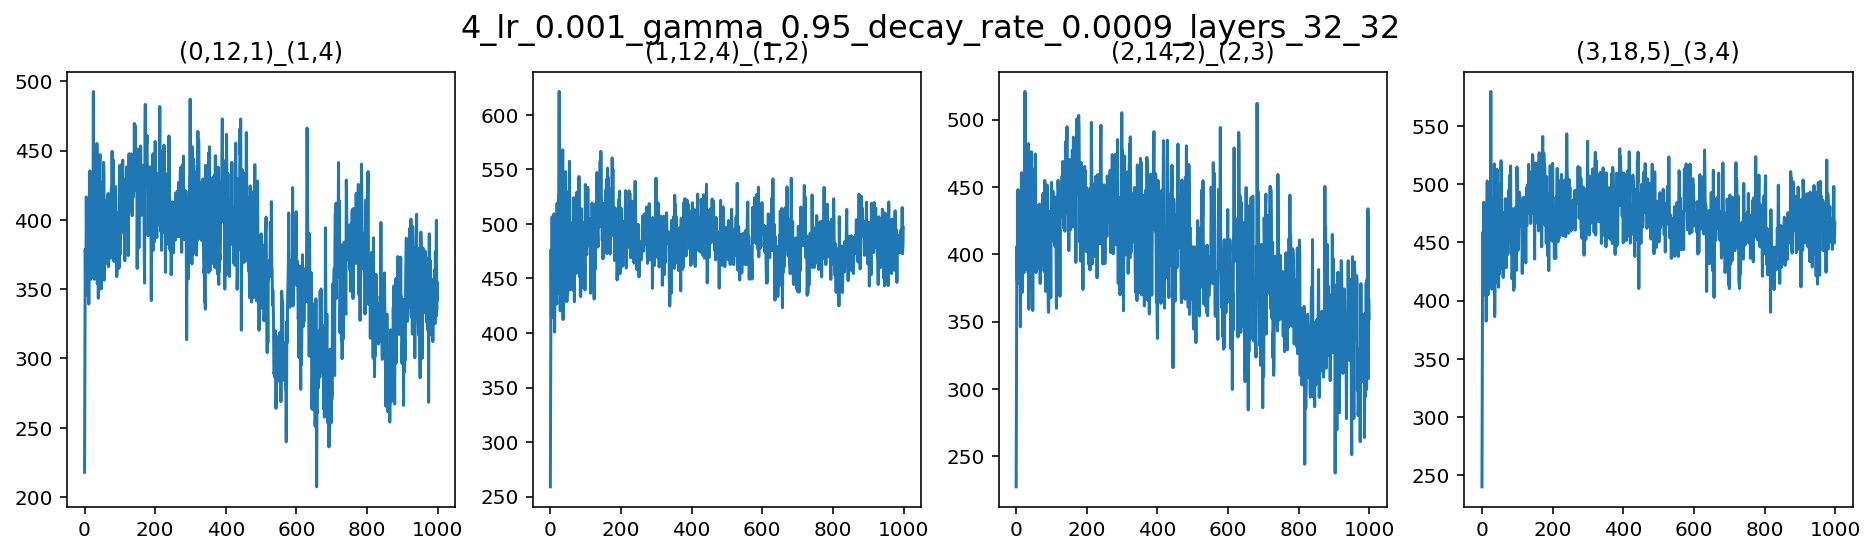

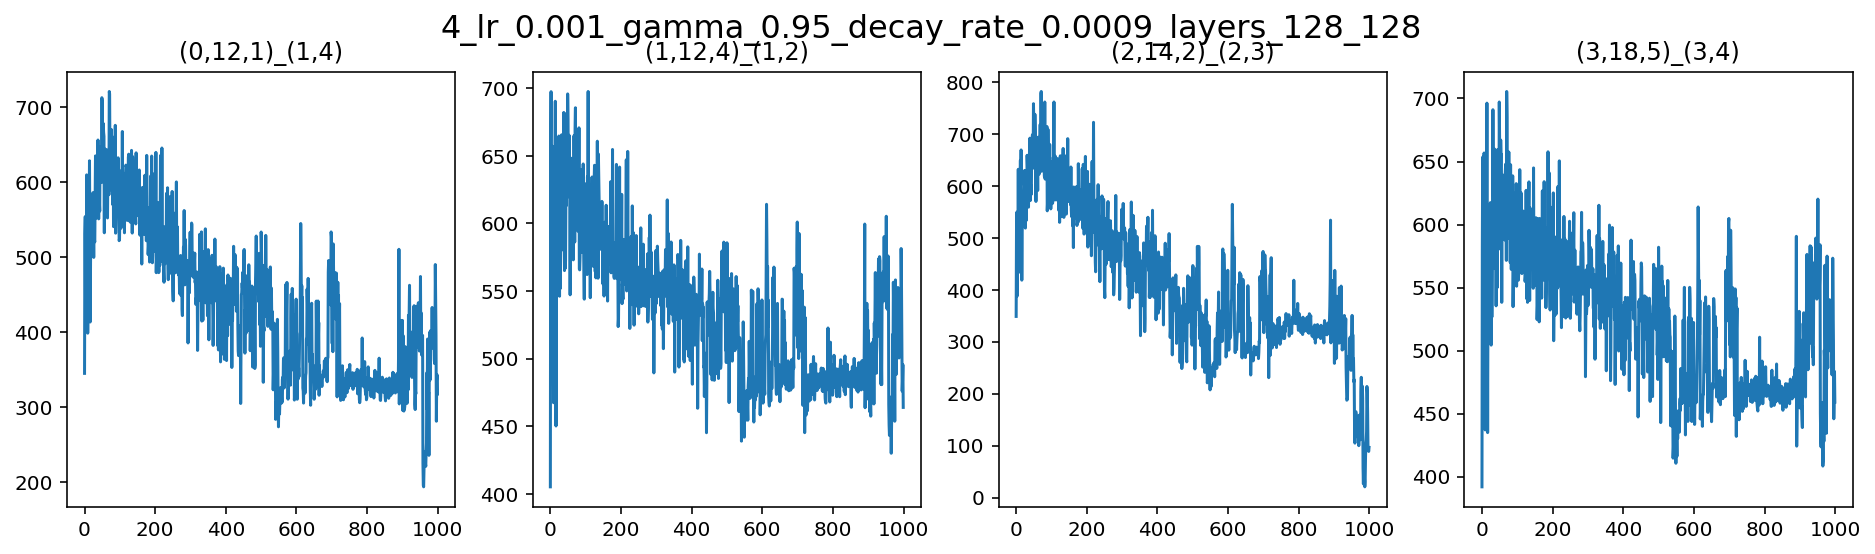

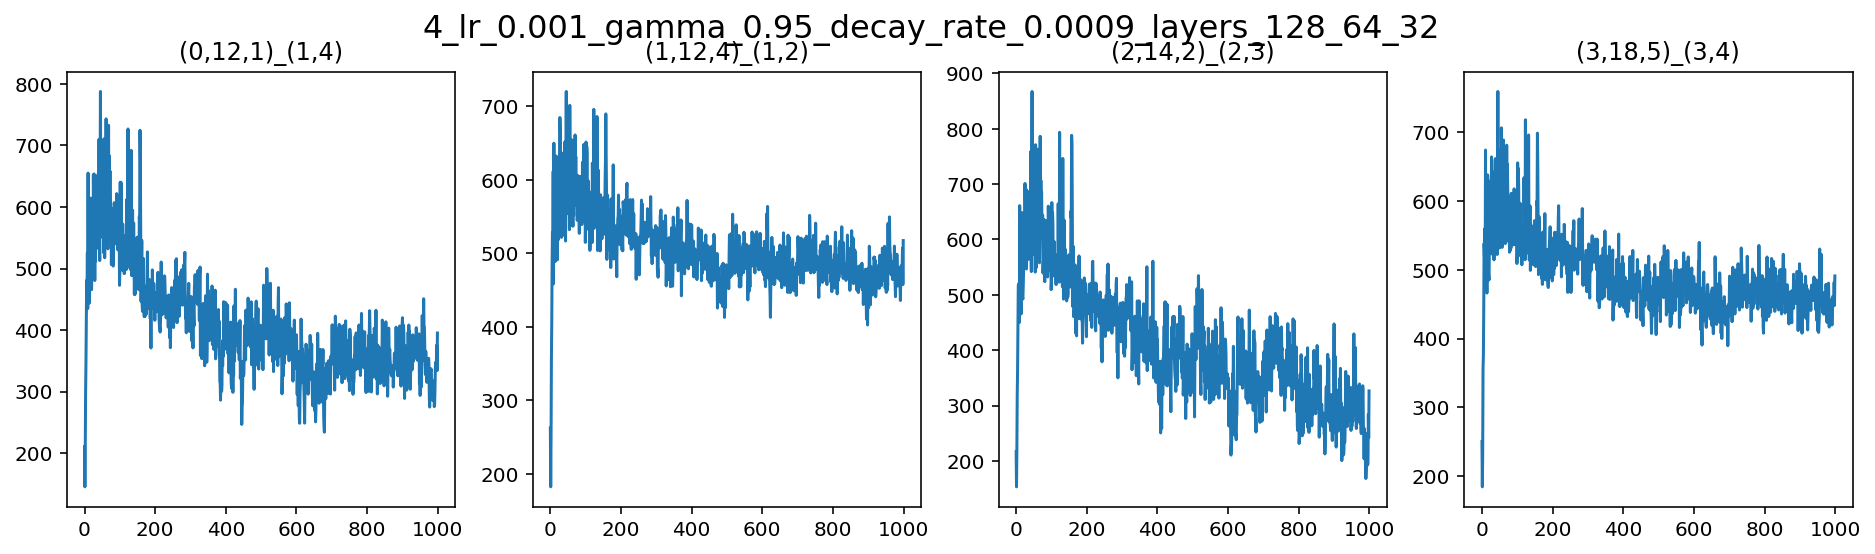

In [22]:
for index, params in enumerate(hp_params):
    name = get_model_name(params)
    with open(data_folder + name + "_tracked_states.pkl", 'rb') as handle:
        tracked_states = pickle.load(handle)
    plot_tracked_values(tracked_states, name=name)

In [23]:
stats=None

In [24]:
def collect_stats(df):
    global stats
    if stats is not None:
        stats = pd.concat([stats, df], axis=0)
    else:
        stats = df
    return df

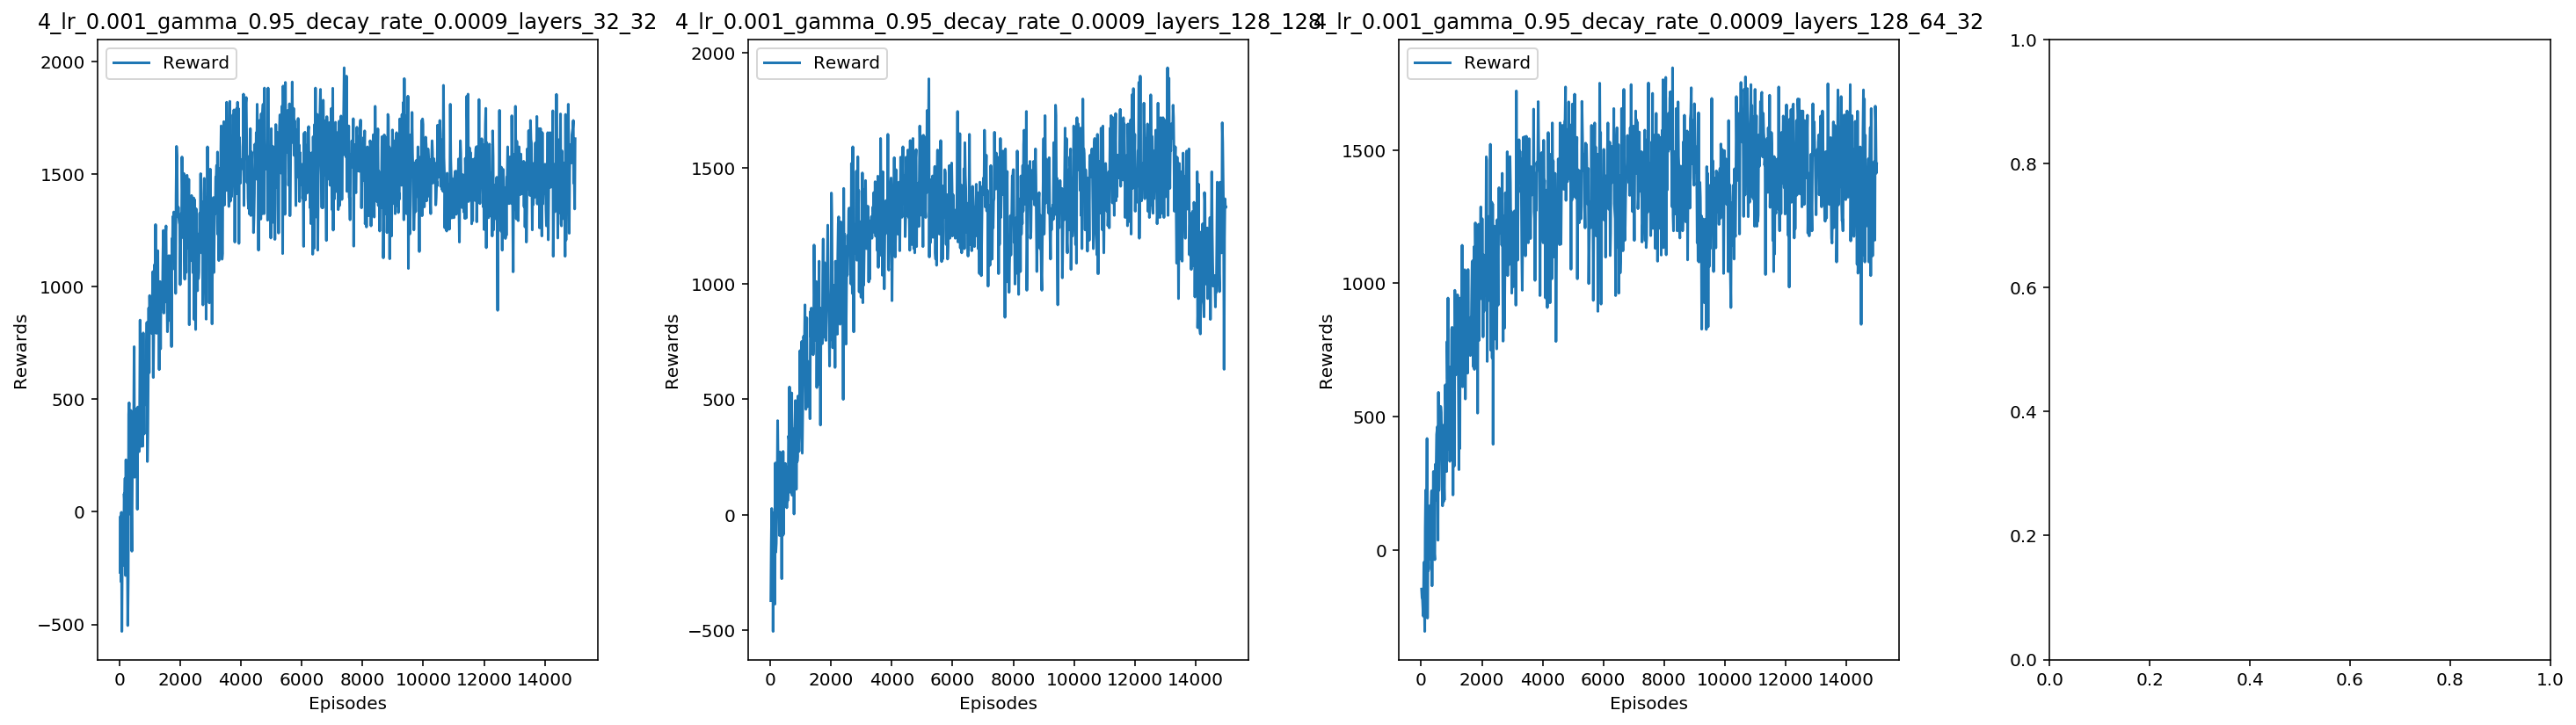

In [25]:
import math
columns = 4
rows = math.ceil(len(hp_params)/columns)
fig_height = rows * 5
fig, axs = plt.subplots(rows, columns, figsize=(25, fig_height))
df = None
for index, params in enumerate(hp_params):
    name = get_model_name(params)

    plt.subplot(rows, columns, index + 1, title=name)

    model_data = pd.read_csv(data_folder + name + ".csv")
    collect_stats(model_data)
    plt.plot(model_data['episode'], model_data['reward'], label='Reward')

    plt.title(name)
    plt.ylabel('Rewards')
    plt.xlabel('Episodes')
    plt.legend(loc="upper left")

plt.subplots_adjust(top=0.99, bottom=0.01, hspace=0.4, wspace=0.3)
plt.savefig('models_{}_4.png'.format(EPISODES))
plt.show()

In [26]:
pd.set_option('display.max_colwidth', -1)
pd.set_option('display.max_rows', None)

df1 = stats.groupby('name').agg(avg_reward=('reward', np.mean),
                                max_reward=('reward',
                                            max)).sort_values('avg_reward',
                                                              ascending=False)
display(df1)

,avg_reward,max_reward
name,,
4_lr_0.001_gamma_0.95_decay_rate_0.0009_layers_32_32,1375.532,1971.0
4_lr_0.001_gamma_0.95_decay_rate_0.0009_layers_128_64_32,1255.255,1809.0
4_lr_0.001_gamma_0.95_decay_rate_0.0009_layers_128_128,1224.058,1935.0
